In [182]:
import pyhf
import json
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm
import matplotlib
import numpy as np
import uproot
from matplotlib import cm
from iminuit import Minuit
matplotlib.rcParams['figure.facecolor'] = 'white'

# Beeston-Barlow (BB) lite function

## Beeston-Barlow

The complete BB likelihood for a single bin assumes Poisson distributed data and Poisson distributed MC production of the template. The total likelihood is:
$$
\begin{align}
    \log{\mathcal{L}_{i}} &= \log{\mathcal{L}_{data, i}} + \log{\mathcal{L}_{nuisance, i}}\\
        &= D_i\log{f_i} - f_i - \log{D_i!} \\
        &+ \sum_j a_{i,j}\log{A_{i,j}} - A_{i,j} - \log{a_{i,j}!}\\
    f_i &= \sum_j p_j A_{i,j} \\
    p_j &= \frac{\hat{\mathcal{N}}_j}{\mathcal{N}_{MC, j}}
\end{align}
$$
with $i$ the index running on all bins and $j$ running on the populations.
This introduces one nuisance parameter per bin per population. This can be reduced to one non-linear equation per bin (see [Beeston-Barlow](https://doi.org/10.1016/0010-4655(93)90005-W)).  


It has been observed that the finite precision of computers can introduce discrete jumps in the likelihood. Additionally, whenever using interpolation techniques between histograms such as template morphing, every histogram must be included in the likelihood, and in case of more sofisticated morphing techniques, the equations for the $A_{i,j}$s don't decouple anymore, making the search of the maximium of the likelihood expensive or impossible.

## Conway approximation
Conway (see [Conway](https://indico.cern.ch/event/107747/contributions/32677/attachments/24368/35057/conway.pdf)) argues that, eventually, only the total statistical uncertainty on $f_i$ is relevant and introduces a multiplying factor per bin with expected value 1 and distributed with a gaussian of with equal to the relative statistical uncertainty on the bin estimate:
$$
\begin{align}
    \log{\mathcal{L}_{nuisance, i}} &= \frac{(\beta_i - 1)^2}{2 V_{\beta_i}}\\
    f_i &= \beta_i \sum_j p_j a_{i,j} \\
    V_{\beta_i} &= \frac{\sum_j p_j^2 a_{i,j}}{(\sum_j p_j a_{i,j})^2}
\end{align}
$$

For a given set of the other parameters, the $\beta_i$ are univoquelly determined with a 2nd order equation:
$$
\beta_i^2 + (f_i V_{\beta_i} - 1)\beta_i - D_iV_{\beta_i} = 0
$$

## Dembinski-Abdelmotteleb approximation

This is a good approximation in case each sample has a high enough statistics so that the Poisson nuisances can be approximated by a normal distribution. An alternative approach ([Dembinski-Abdelmotteleb](https://doi.org/10.1140/epjc/s10052-022-11019-z)) is to use an effective Poisson instead, to model the asymmetry in low statistics scenarios. The effective Poisson will have average $\mu_{i,eff}$:
$$
\mu_{i,eff} = \frac{1}{V_{\beta_i}}
$$

The authors propose a closed analytical expression for $\beta_i$ in such a case:
$$
\begin{align}
    \beta_i &= \frac{D_i + \mu_{i,eff}}{\mu_0 + \mu_{i,eff}}\\
    \mu_0 &= \sum_j p_j a_{i,j}
\end{align}
$$

This still requires that an estimate of the bin size can be made and that in a given bin if $a_{i,j}=0$, that population $j$ should be expected to contribute negligibly to the estimate of bin $i$.

The contribution from parametric PDFs is naturally included by defining $f_i$ as:
$$
    f_i = \beta_i\mu_0 + f(i|\theta)
$$
with $f(i|\theta)$ the binned PDF depending on parameters $\theta$ computed in bin $i$.

In [183]:
def BBliteBeta(Di, mu0, mueff):
    betas = (Di + mueff)/(mu0 + mueff + (mu0 == 0))
    return betas + (betas == 0)

class histHandler:
    def __init__(self, channels, dataName, BKGnames, var1, var2):
        self.channels = channels
        self.dataName = dataName
        self.BKGnames = BKGnames
        self.var1 = var1
        self.var2 = var2
        self.DataArray = []
        self.DataArrayToy = []
        self.BKGarray = []
        self.BKGarrayToy = []
        self.nMCs = []
        self.initializeArrays()
        
    # Prepare histograms
    def initializeArrays(self):
        # Produce 1D hist of data
        hist = []
        for channel in self.channels.keys():
            hist.append(self.channels[channel][self.dataName].flatten())
        self.DataArray = np.concatenate(hist)
        
        # Produce 1D BKG arrays
        hist = []
        nMCs = []
        for i in range(len(self.BKGnames)):
            thist = []
            for channel in self.channels.keys():
                thist.append(self.channels[channel][self.BKGnames[i]].flatten())
            hist.append(np.concatenate(thist))
            nMCs.append(hist[-1].sum())
        self.BKGarray = np.array(hist)
        self.nMCs = np.array(nMCs)
    
    def getEstimateBB(self, yields, Ai):
        temphists = np.copy(Ai)
        totMCs = self.nMCs
        temphists = np.matmul(yields/totMCs, temphists)
        return temphists
    
    def getEstimateBBUncertainty(self, yields, Ai):
        temphists = np.copy(Ai)
        totMCs = self.nMCs
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return np.sqrt(temphists)
    
    def getEstimateBBVariance(self, yields, Ai):
        temphists = np.copy(Ai)
        totMCs = self.nMCs
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return temphists
    
    def getEstimate(self, yields, betas = 1, nus=1):
        temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
        temphists *= betas*nus
        totMCs = self.nMCs
        temphists = np.matmul(yields/totMCs, temphists)
        return temphists
    
    def getEstimateToy(self, yields, betas = 1, nus=1):
        temphists = np.copy(self.BKGarrayToy)  # Create a copy of self.BKGarray
        temphists *= betas*nus
        totMCs = self.nMCs
        temphists = np.matmul(yields/totMCs, temphists)
        return temphists
    
    def getEstimateUncertaintyToy(self, yields, betas = 1, nus=1):
        temp = np.copy(self.BKGarrayToy)
        totMCs = self.nMCs
        temp *= np.power(betas*nus, 2)
        temp = np.matmul(np.power(yields/totMCs, 2), temp)
        return np.sqrt(temp)
    
    def getEstimateVarianceToy(self, yields, betas = 1, nus=1):
        temp = np.copy(self.BKGarrayToy)
        totMCs = self.nMCs
        temp *= np.power(betas*nus, 2)
        temp = np.matmul(np.power(yields/totMCs, 2), temp)
        return temp

    def getEstimateUncertainty(self, yields, betas = 1, nus=1):
        temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
        totMCs = self.nMCs
        temphists *= np.power(betas*nus, 2)
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return np.sqrt(temphists)

    def getEstimateVariance(self, yields, betas = 1, nus=1):
        temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
        totMCs = self.nMCs
        temphists *= np.power(betas*nus, 2)
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return temphists

    def generateToy(self, yields, betas = 1, nus=1, fluctuateTemplates = False):
        if fluctuateTemplates:
            temphists = np.copy(self.BKGarray)
            #temphists *= betas*nus
            temphists = (np.random.poisson(temphists)).astype(float)
            self.BKGarrayToy = temphists
        else:
            self.BKGarrayToy = np.copy(self.BKGarray)
        
        self.DataArrayToy = np.random.poisson(self.getEstimate(yields, betas, nus))


# Likelihood definition
In [Baker-Cowsins](https://doi.org/10.1016/0167-5087(84)90016-4) it is shown that for a Poisson distributed bins, the likelihood can be written in a form that is asymptotically behaving as a $\chi^2$:
$$
\begin{align}
    \lambda_i &= -2 \log{\frac{\mathcal{L}(D_i|f_i)}{\mathcal{L}(D_i|D_i)}}\\
        &= -2(D_i\log{f_i} - f_i - D_i\log{D_i} + D_i)
\end{align}
$$
where $D_i$ is the counts in the data bin $i$ and $f_i$ is the predicted counts in the bin $i$. This allows to remove the factorial term and can be used for a full FC construction as the term $\mathcal{L}(D_i|D_i)$ cancels out.

This formalism can be extended to any term in the likelihood by dividing by their value at the nominal. For the BB-lite likelihood means subtracting the $\log{\mathcal{L}}$ computed in $\beta_i=1$.
The total likelihood of the single bin  becomes:
$$
\begin{align}
    \lambda_i &= -2 \log{\frac{\mathcal{L}(D_i|f_i)}{\mathcal{L}(D_i|D_i)}}\\
        &= -2[D_i\log{f_i} - f_i - D_i\log{D_i} + D_i \\
        &+ \mu_{i,eff}(\log{\beta_i\mu_{i,eff}} - \beta_i) - \mu_{i,eff}(\log{\mu_{i,eff}} - 1)]
\end{align}
$$

The total likelihood will then include any additional contribution from systematic parameters ($\alpha_k$) and penalty terms ($P$) to set additional constraint:
$$
\begin{align}
    \lambda = \sum_i \lambda_i + \sum_k \alpha_k^2 + P
\end{align}
$$
with $\alpha_k$ parametrized so that the expected value is 0 and the standard deviation is 1.

In [184]:
def likelihood(Di, fPar, mu, mueff, betas, alphas, P = 0):
    f = mu + fPar
    binnedTerm = Di*np.log(f + (f == 0)) - f - Di*np.log(Di + (Di == 0)) + Di
    binnedTerm = binnedTerm + mueff*(np.log(betas) - (betas - 1))
    binnedTerm = -2*np.sum(binnedTerm)
    return binnedTerm + np.sum(np.power(alphas, 2)) + P

def likelihoodBB(Di, fPar, mu, ai, Ai, alphas, P = 0):
    f = mu + fPar
    binnedTerm = Di*np.log(f + (f == 0)) - f - Di*np.log(Di + (Di == 0)) + Di
    binnedTerm += np.sum(ai*np.log(Ai) - Ai - ai*np.log(ai) + ai)
    binnedTerm = -2*np.sum(binnedTerm)
    return binnedTerm + np.sum(np.power(alphas, 2)) + P

# Data preparation
## Channel declaration and globals

In [185]:
channels = {
    'ch1': {
        'name': 'X17 2023, low angle',
        'Esum': [15, 20, 5], # [min, max, nBins]
        'Angle': [20, 80, 6]
    },
    'ch2': {
        'name': 'X17 2023, low energy, high angle',
        'Esum': [15, 16, 1],
        'Angle': [80, 180, 5]
    },
    'ch3': {
        'name': 'X17 2023, high energy, high angle',
        'Esum': [16, 20, 2],
        'Angle': [80, 180, 10]
    }
}
massElectron = 0.5109989461 #MeV
alphares = 0.01
alphafield = 0.01

esumCutLow = 16
esumCutHigh = 20
angleCutLow = 115
angleCutHigh = 160

workDir = './results/'
dataFile = 'data2023.root'
MCFile = 'MC2023tot.root'


## Useful functions

In [186]:
matplotlib.rcParams.update({'font.size': 30})
def plotChannels(channels, sample='dataHist', title='Data'):
    matplotlib.rcParams.update({'font.size': 30})
    hists = []
    maxBin = 0
    minEsum = 100
    maxEsum = 0
    minAngle = 180
    maxAngle = 0
    # check if sample is a 
    if type(sample) == list:
        fig = plt.figure(figsize=(14*len(sample)*1.1, 14), dpi=100)
        plt.suptitle(title)
        numberOfSubPlots = len(sample)
        for s in sample:
            hists = []
            plt.subplot(1, numberOfSubPlots, sample.index(s)+1)
            plt.title(s)
            for channel in channels.keys():
                hist = channels[channel][s]/(channels[channel]['Esum'][1] - channels[channel]['Esum'][0])*channels[channel]['Esum'][2]
                maxBin = max(maxBin, np.max(hist))
                minEsum = min(minEsum, channels[channel]['Esum'][0])
                maxEsum = max(maxEsum, channels[channel]['Esum'][1])
                minAngle = min(minAngle, channels[channel]['Angle'][0])
                maxAngle = max(maxAngle, channels[channel]['Angle'][1])
                hists.append(hist)
            
            for channel, hist in zip(channels.keys(), hists):
                plt.imshow(hist, cmap='coolwarm', extent=[channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Esum'][0], channels[channel]['Esum'][1]], aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm(vmin=1, vmax=maxBin), origin='lower')
                plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
                plt.ylabel(r'$E_{\mathrm{sum}}$ [MeV]')
                # Draw bin borders as well
                for line in np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1):
                    plt.hlines(line, channels[channel]['Angle'][0], channels[channel]['Angle'][1], colors='k', linestyles='dashed')
                for line in np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1):
                    plt.vlines(line, channels[channel]['Esum'][0], channels[channel]['Esum'][1], colors='k', linestyles='dashed')
                plt.grid()
            plt.xlim(minAngle, maxAngle)
            plt.ylim(minEsum, maxEsum)
            cbar = plt.colorbar()
            cbar.set_label(r'Counts/MeV/deg')
        plt.show()
    else: 
        fig = plt.figure(figsize=(21, 14), dpi=100)
        plt.title(title)
        for channel in channels.keys():
            hist = channels[channel][sample]/(channels[channel]['Esum'][1] - channels[channel]['Esum'][0])*channels[channel]['Esum'][2]
            maxBin = max(maxBin, np.max(hist))
            minEsum = min(minEsum, channels[channel]['Esum'][0])
            maxEsum = max(maxEsum, channels[channel]['Esum'][1])
            minAngle = min(minAngle, channels[channel]['Angle'][0])
            maxAngle = max(maxAngle, channels[channel]['Angle'][1])
            hists.append(hist)

        for channel, hist in zip(channels.keys(), hists):
            plt.imshow(hist, cmap='coolwarm', extent=[channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Esum'][0], channels[channel]['Esum'][1]], aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm(vmin=1, vmax=maxBin), origin='lower')
            plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
            plt.ylabel(r'$E_{\mathrm{sum}}$ [MeV]')
            # Draw bin borders as well
            for line in np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1):
                plt.hlines(line, channels[channel]['Angle'][0], channels[channel]['Angle'][1], colors='k', linestyles='dashed')
            for line in np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1):
                plt.vlines(line, channels[channel]['Esum'][0], channels[channel]['Esum'][1], colors='k', linestyles='dashed')
            plt.grid()
        plt.xlim(minAngle, maxAngle)
        plt.ylim(minEsum, maxEsum)
        cbar = plt.colorbar()
        cbar.set_label(r'Counts/MeV/deg')
        plt.show()

# Create up/down  variables for field and resolution scaling
def createUpDownVariables(p, simp, alphares, alphafield):
    pres_up = (p - simp)*(1 + alphares) + simp
    pres_dn = (p - simp)*(1 - alphares) + simp
    esumres_up = np.sqrt(np.sum(np.power(pres_up[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumres_up = esumres_up + np.sqrt(np.sum(np.power(pres_up[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    angleres_up = np.arccos(np.sum(pres_up[:3]*pres_up[3:6], axis=0)/np.sqrt(np.sum(np.power(pres_up[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pres_up[3:6], 2), axis=0)))*180/np.pi
    esumres_dn = np.sqrt(np.sum(np.power(pres_dn[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumres_dn = esumres_dn + np.sqrt(np.sum(np.power(pres_dn[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    angleres_dn = np.arccos(np.sum(pres_dn[:3]*pres_dn[3:6], axis=0)/np.sqrt(np.sum(np.power(pres_dn[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pres_dn[3:6], 2), axis=0)))*180/np.pi
    
    pfield_up = p*(1 + alphafield)
    pfield_dn = p*(1 - alphafield)
    esumfield_up = np.sqrt(np.sum(np.power(pfield_up[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumfield_up = esumfield_up + np.sqrt(np.sum(np.power(pfield_up[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    anglefield_up = np.arccos(np.sum(pfield_up[:3]*pfield_up[3:6], axis=0)/np.sqrt(np.sum(np.power(pfield_up[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pfield_up[3:6], 2), axis=0)))*180/np.pi
    esumfield_dn = np.sqrt(np.sum(np.power(pfield_dn[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumfield_dn = esumfield_dn + np.sqrt(np.sum(np.power(pfield_dn[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    anglefield_dn = np.arccos(np.sum(pfield_dn[:3]*pfield_dn[3:6], axis=0)/np.sqrt(np.sum(np.power(pfield_dn[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pfield_dn[3:6], 2), axis=0)))*180/np.pi
    
    # Apply cuts
    selectionres_up = (esumres_up < esumCutLow) | (esumres_up > esumCutHigh) | (angleres_up < angleCutLow) | (angleres_up > angleCutHigh)
    selectionres_dn = (esumres_dn < esumCutLow) | (esumres_dn > esumCutHigh) | (angleres_dn < angleCutLow) | (angleres_dn > angleCutHigh)
    selectionfield_up = (esumfield_up < esumCutLow) | (esumfield_up > esumCutHigh) | (anglefield_up < angleCutLow) | (anglefield_up > angleCutHigh)
    selectionfield_dn = (esumfield_dn < esumCutLow) | (esumfield_dn > esumCutHigh) | (anglefield_dn < angleCutLow) | (anglefield_dn > angleCutHigh)
    
    return esumres_up[selectionres_up], angleres_up[selectionres_up], esumres_dn[selectionres_dn], angleres_dn[selectionres_dn], esumfield_up[selectionfield_up], anglefield_up[selectionfield_up], esumfield_dn[selectionfield_dn], anglefield_dn[selectionfield_dn]

def combinedBins(channels, sample='dataHist'):
    bins = []
    for channel in channels.keys():
        bin = np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1)
        for i in range(channels[channel]['Esum'][2]):
            bins.append(np.diff(bin))
    return np.concatenate(bins)



## Load data

Channel definition and optimized binning. The channels are defined as different cuts:
* Channel 1: "low relative angle". Here a finer binning is used as this is more sensitive to the resolutions and shape systematics below 100 deg. 0.5 MeV and 5 deg binning is used.
* Channel 2: "high relative angle, low energy". For higher relative angles the MC events are not enough to provide an estimate of the data with a fine binning. One nergy bin only is used between 15 and 16 MeV.
* Channel 3: "high relative angle, high energy". For higher relative angles the MC events are not enough to provide an estimate of the data with a fine binning. One energy bin only is used between 16 and 20 MeV.

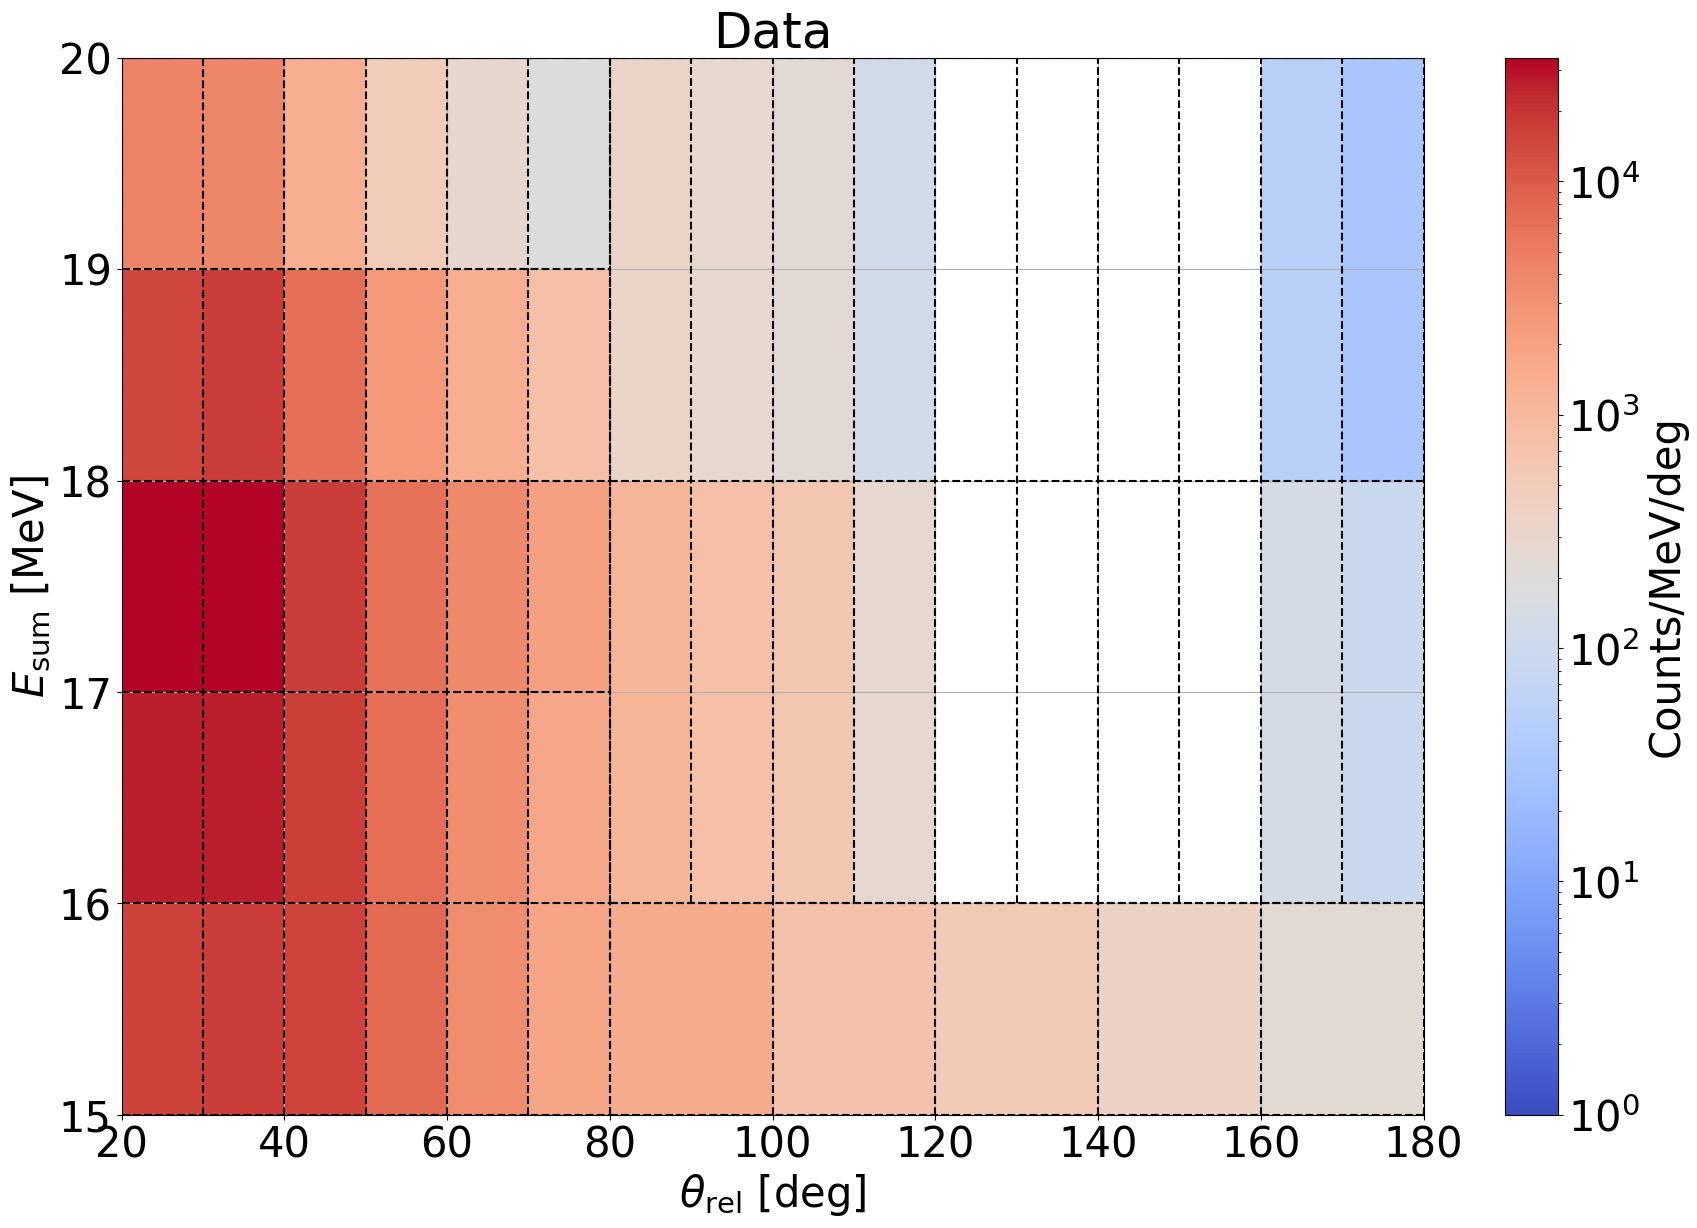

In [187]:

with uproot.open(workDir + dataFile + ':ntuple') as f:
    esum = f.arrays(['esum'], library='np')['esum']*1e3
    angle = f.arrays(['angle'], library='np')['angle']
    for channel in channels.keys():
        dataHist = np.histogram2d(esum, angle, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])
        channels[channel]['dataHist'] = dataHist[0]
        channels[channel]['dataHistErr'] = np.sqrt(dataHist[0])

plotChannels(channels)

## Load the Monte Carlo templates
The different background populations aer identified through the ecode branch as follows:
* ecode = 1: IPC 17.6 MeV
* ecode = 2: IPC 17.9 MeV
* ecode = 3: IPC 18.1 MeV
* ecode = 4: IPC 14.6 MeV
* ecode = 5: IPC 14.9 MeV
* ecode = 6: IPC 15.1 MeV
* ecode = 7: EPC 18 MeV
* ecode = 8: EPC 15 MeV

In [188]:
BKGnames = ['IPC 17.6', 'IPC 17.9', 'IPC 18.1', 'IPC 14.6', 'IPC 14.9', 'IPC 15.1', 'EPC 18', 'EPC 15']


with uproot.open(workDir + MCFile + ':ntuple') as f:
    MC = f.arrays(['esum', 'angle', 'ecode', 'px_pos', 'py_pos', 'pz_pos', 'px_ele', 'py_ele', 'pz_ele', 'simpx_pos', 'simpy_pos', 'simpz_pos', 'simpx_ele', 'simpy_ele', 'simpz_ele'], library='np')
    
    for i in range(1, 9): # running on ecode
        esum = MC['esum'][MC['ecode'] == i]*1e3
        angle = MC['angle'][MC['ecode'] == i]
        selection = (esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)
        esum = esum[selection]
        angle = angle[selection]
        p = np.vstack((MC['px_pos'][MC['ecode'] == i], MC['py_pos'][MC['ecode'] == i], MC['pz_pos'][MC['ecode'] == i], MC['px_ele'][MC['ecode'] == i], MC['py_ele'][MC['ecode'] == i], MC['pz_ele'][MC['ecode'] == i]))*1e3
        simp = np.vstack((MC['simpx_pos'][MC['ecode'] == i], MC['simpy_pos'][MC['ecode'] == i], MC['simpz_pos'][MC['ecode'] == i], MC['simpx_ele'][MC['ecode'] == i], MC['simpy_ele'][MC['ecode'] == i], MC['simpz_ele'][MC['ecode'] == i]))*1e3
        
        #if i == 8:
        #    esum = esum[:3861]
        #    angle = angle[:3861]
        #    p = p[:, :3861]
        #    simp = simp[:, :3861]
        #elif i == 7:
        #    esum = esum[:6585]
        #    angle = angle[:6585]
        #    p = p[:, :6585]
        #    simp = simp[:, :6585]
            
        
        esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, alphares, alphafield)
        
        factor = 1
        #if i == 8:
        #    factor = 2
        #elif i == 7:
        #    factor = 2
        #elif i != 0:
        #    factor = 3
        for channel in channels.keys():
            hist = np.histogram2d(esum, angle, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            histres_up = np.histogram2d(esumres_up, angleres_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            histres_dn = np.histogram2d(esumres_dn, angleres_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            histfield_up = np.histogram2d(esumfield_up, anglefield_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            histfield_dn = np.histogram2d(esumfield_dn, anglefield_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
            
            channels[channel][BKGnames[i-1]] = hist
            channels[channel][BKGnames[i-1] + 'res_up'] = histres_up
            channels[channel][BKGnames[i-1] + 'res_dn'] = histres_dn
            channels[channel][BKGnames[i-1] + 'field_up'] = histfield_up
            channels[channel][BKGnames[i-1] + 'field_dn'] = histfield_dn
        samples = [BKGnames[i-1], BKGnames[i-1] + 'res_up', BKGnames[i-1] + 'res_dn', BKGnames[i-1] + 'field_up', BKGnames[i-1] + 'field_dn']
        #plotChannels(channels, sample=samples, title=BKGnames[i-1])
            
print('nData:', np.sum([channels[channel]['dataHist'].sum() for channel in channels.keys()]))
nBKGs = {}
for i in range(1, 9):
    nBKGs[BKGnames[i-1]] = np.sum([channels[channel][BKGnames[i-1]].sum() for channel in channels.keys()])
    print('n' + BKGnames[i-1], ':', nBKGs[BKGnames[i-1]])

nData: 303717.0
nIPC 17.6 : 158249.0
nIPC 17.9 : 10803.0
nIPC 18.1 : 13923.0
nIPC 14.6 : 42827.0
nIPC 14.9 : 3341.0
nIPC 15.1 : 5115.0
nEPC 18 : 16942.0
nEPC 15 : 3546.0


## Histograms initialization

In [189]:
Hists = histHandler(channels, 'dataHist', BKGnames, 'Esum', 'Angle')
#print(Hists.BKGarray[7])
#print(Hists.getEstimate(np.array([0, 0, 0, 0, 0, 0, 0, 1]), betas=np.ones(len(Hists.DataArray))))
#print(Hists.getEstimate(np.array([0, 0, 0, 0, 0, 0, 0, 1]), betas=0.5*np.ones(len(Hists.DataArray))))
#print(Hists.getEstimate(np.array([0, 0, 0, 0, 0, 0, 0, 1]), betas=np.ones(len(Hists.DataArray))))
#print(Hists.getEstimateUncertainty(np.array([0, 0, 0, 0, 0, 0, 0, 10]), betas=np.ones(len(Hists.DataArray))))
#print(Hists.getEstimateVariance(np.array([0, 0, 0, 0, 0, 0, 0, 10]), betas=np.ones(len(Hists.DataArray))))
#print(Hists.DataArray)
#print(Hists.BKGarray[7])
#print(Hists.channels['ch1'][BKGnames[7]])

# iMinuit likelihood definition
The betas are computed at each likelihood evaluation. Minuit is instead minimizing on the other parameters, like the yields, the X17 mass or/and the systematics $\alpha_k$.

In [190]:
def llBKGOnlyNoBB(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu = Hists.getEstimate(yields)
    
    return likelihood(Hists.DataArray, 0, mu, 0, 1, 0)

# Find starting fit parameters
startingPars = np.array([4e5, 1e4, 1e4, 8e5, 2e3, 2e3, 9e4, 6e4])
logL = Minuit(llBKGOnlyNoBB, startingPars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15'])

for i in range(len(startingPars)):
    logL.limits[i] = (0, None)

logL.simplex(ncall=100000)
logL.strategy = 1
logL.migrad(ncall=100000, iterate=5)
logL.hesse()
startingPars = np.array(logL.values)
globalStartingPars = np.copy(startingPars)

# Fit with BB
def llBKGOnly(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimate(yields)
    Vmu0 = Hists.getEstimateVariance(yields)
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArray, mu0, mueff)
    
    mu = Hists.getEstimate(yields, betas)
    
    return likelihood(Hists.DataArray, 0, mu, mueff, betas, 0)


def llBKGOnlyExplicit(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars[:8]
    betas = pars[8:]
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    
    mu = Hists.getEstimate(yields, betas)
    Vmu = Hists.getEstimateVariance(yields, betas)
    mueff = np.power(mu, 2)/(Vmu + (mu==0))
    
    return likelihood(Hists.DataArray, 0, mu, mueff, betas, 0)

# Fit with BB
def llBKGOnlyIterative(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimate(yields)
    Vmu0 = Hists.getEstimateVariance(yields)
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArray, mu0, mueff)
    
    #for i in range(10):
    while(True):
        mu = Hists.getEstimate(yields, betas=betas)
        Vmu = Hists.getEstimateVariance(yields, betas=betas)
        mueff = np.power(mu, 2)/(Vmu + (mu==0))
        tbetas = BBliteBeta(Hists.DataArray, mu0, mueff)
        if np.allclose(betas, tbetas):
            break
        else:
            betas = tbetas
    
    mu = Hists.getEstimate(yields, betas)
    
    return likelihood(Hists.DataArray, 0, mu, mueff, betas, 0)

logL = Minuit(llBKGOnly, startingPars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15'])
#logL = Minuit(llBKGOnlyIterative, startingPars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15'])

for i in range(len(startingPars)):
    logL.limits[i] = (0, None)

logL.simplex(ncall=100000)
logL.strategy = 2
logL.tol = 1e-10
logL.migrad(ncall=100000, iterate=5)
for i in range(5):
    logL.scan(ncall=1e4)
logL.migrad(ncall=100000, iterate=5)

true = np.array([True, True, True, True, True, True, True, True])
false = np.array([False, False, False, False, False, False, False, False])

logL.hesse()
pars = np.array(logL.values)#/Hists.nMCs
covariance = np.array(logL.covariance)

print(logL.accurate)
print(logL.valid)
print(logL.fval)
print('DOF:', len(pars) + len(Hists.DataArray))

MAXLikelihood = logL.fval

print(pars)
print(logL.errors)
print(logL.fval)
mu0 = Hists.getEstimate(pars)
Vmu0 = Hists.getEstimateVariance(pars)
mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))

betas = BBliteBeta(Hists.DataArray, mu0, mueff)

#while(True):
#    mu = Hists.getEstimate(pars, betas=betas)
#    Vmu = Hists.getEstimateVariance(pars, betas=betas)
#    mueff = np.power(mu, 2)/(Vmu + (mu==0))
#    tbetas = BBliteBeta(Hists.DataArray, mu0, mueff)
#    if np.allclose(betas, tbetas):
#        break
#    else:
#        betas = tbetas

print(llBKGOnlyIterative(pars))
print(llBKGOnlyIterative(startingPars))


True
True
422.7285308885596
DOF: 63
[6.03509084e+04 6.33601327e-09 2.70485279e-09 2.80917134e-08
 3.68047052e+04 4.91584773e-10 1.10718233e+05 9.84787221e+04]
<ErrorView nIPC176=1576.2413007029973 nIPC179=23.10118668420943 nIPC181=19.060656549138177 nIPC146=146.63147652488027 nIPC149=2346.0943444244585 nIPC151=30.895818215833234 nEPC18=2765.0560054820235 nEPC15=3427.5445672956703>
422.7285308885596
422.7285308885596
619.8727756669794


/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_265/2942679115.py:33: RuntimeWarning: invalid value encountered in true_divide
  effectiveHist = np.power(histEstimate/histEstimateError, 2)
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_265/2942679115.py:98: RuntimeWarning: invalid value encountered in true_divide
  redExpectedFit = redExpectedFit/reddData
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_265/2942679115.py:103: RuntimeWarning: invalid value encountered in true_divide
  redResiduals = redResiduals/reddData
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_265/2942679115.py:104: RuntimeWarning: invalid value encountered in true_divide
  reddData = reddData/reddData


IPC 17.6 63448.09445952968 -> 61494.14101825497 +- 1606.100179117387
IPC 17.9 0.009371969517529388 -> 6.378404441232683e-09 +- 23.25574544662088
IPC 18.1 0.0007883454308981186 -> 2.7050119749458835e-09 +- 19.061778326309167
IPC 14.6 59934.95740615257 -> 2.8412950627187268e-08 +- 148.30825174613383
IPC 14.9 0.027393625493031815 -> 36766.62890915114 +- 2343.6671910309356
IPC 15.1 0.05913277682960971 -> 4.918807523037751e-10 +- 30.9144203506545
EPC 18 119439.00247844768 -> 111236.24786119048 +- 2777.9928109054345
EPC 15 60895.162195900586 -> 94219.98226309687 +- 3279.3194444323753
chi2: 453.075148095728
dof: 39
p-value: 6.026012285374207e-72
Z-score: 17.93735099989816


/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_265/2942679115.py:33: RuntimeWarning: invalid value encountered in true_divide
  effectiveHist = np.power(histEstimate/histEstimateError, 2)
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_265/2942679115.py:98: RuntimeWarning: invalid value encountered in true_divide
  redExpectedFit = redExpectedFit/reddData
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_265/2942679115.py:103: RuntimeWarning: invalid value encountered in true_divide
  redResiduals = redResiduals/reddData
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_265/2942679115.py:104: RuntimeWarning: invalid value encountered in true_divide
  reddData = reddData/reddData


IPC 17.6 63448.09445952968 -> 61494.14101825497 +- 1606.100179117387
IPC 17.9 0.009371969517529388 -> 6.378404441232683e-09 +- 23.25574544662088
IPC 18.1 0.0007883454308981186 -> 2.7050119749458835e-09 +- 19.061778326309167
IPC 14.6 59934.95740615257 -> 2.8412950627187268e-08 +- 148.30825174613383
IPC 14.9 0.027393625493031815 -> 36766.62890915114 +- 2343.6671910309356
IPC 15.1 0.05913277682960971 -> 4.918807523037751e-10 +- 30.9144203506545
EPC 18 119439.00247844768 -> 111236.24786119048 +- 2777.9928109054345
EPC 15 60895.162195900586 -> 94219.98226309687 +- 3279.3194444323753
chi2: 34.450589398659325
dof: 39
p-value: 0.6773496105739056
Z-score: 0.4160825334605477


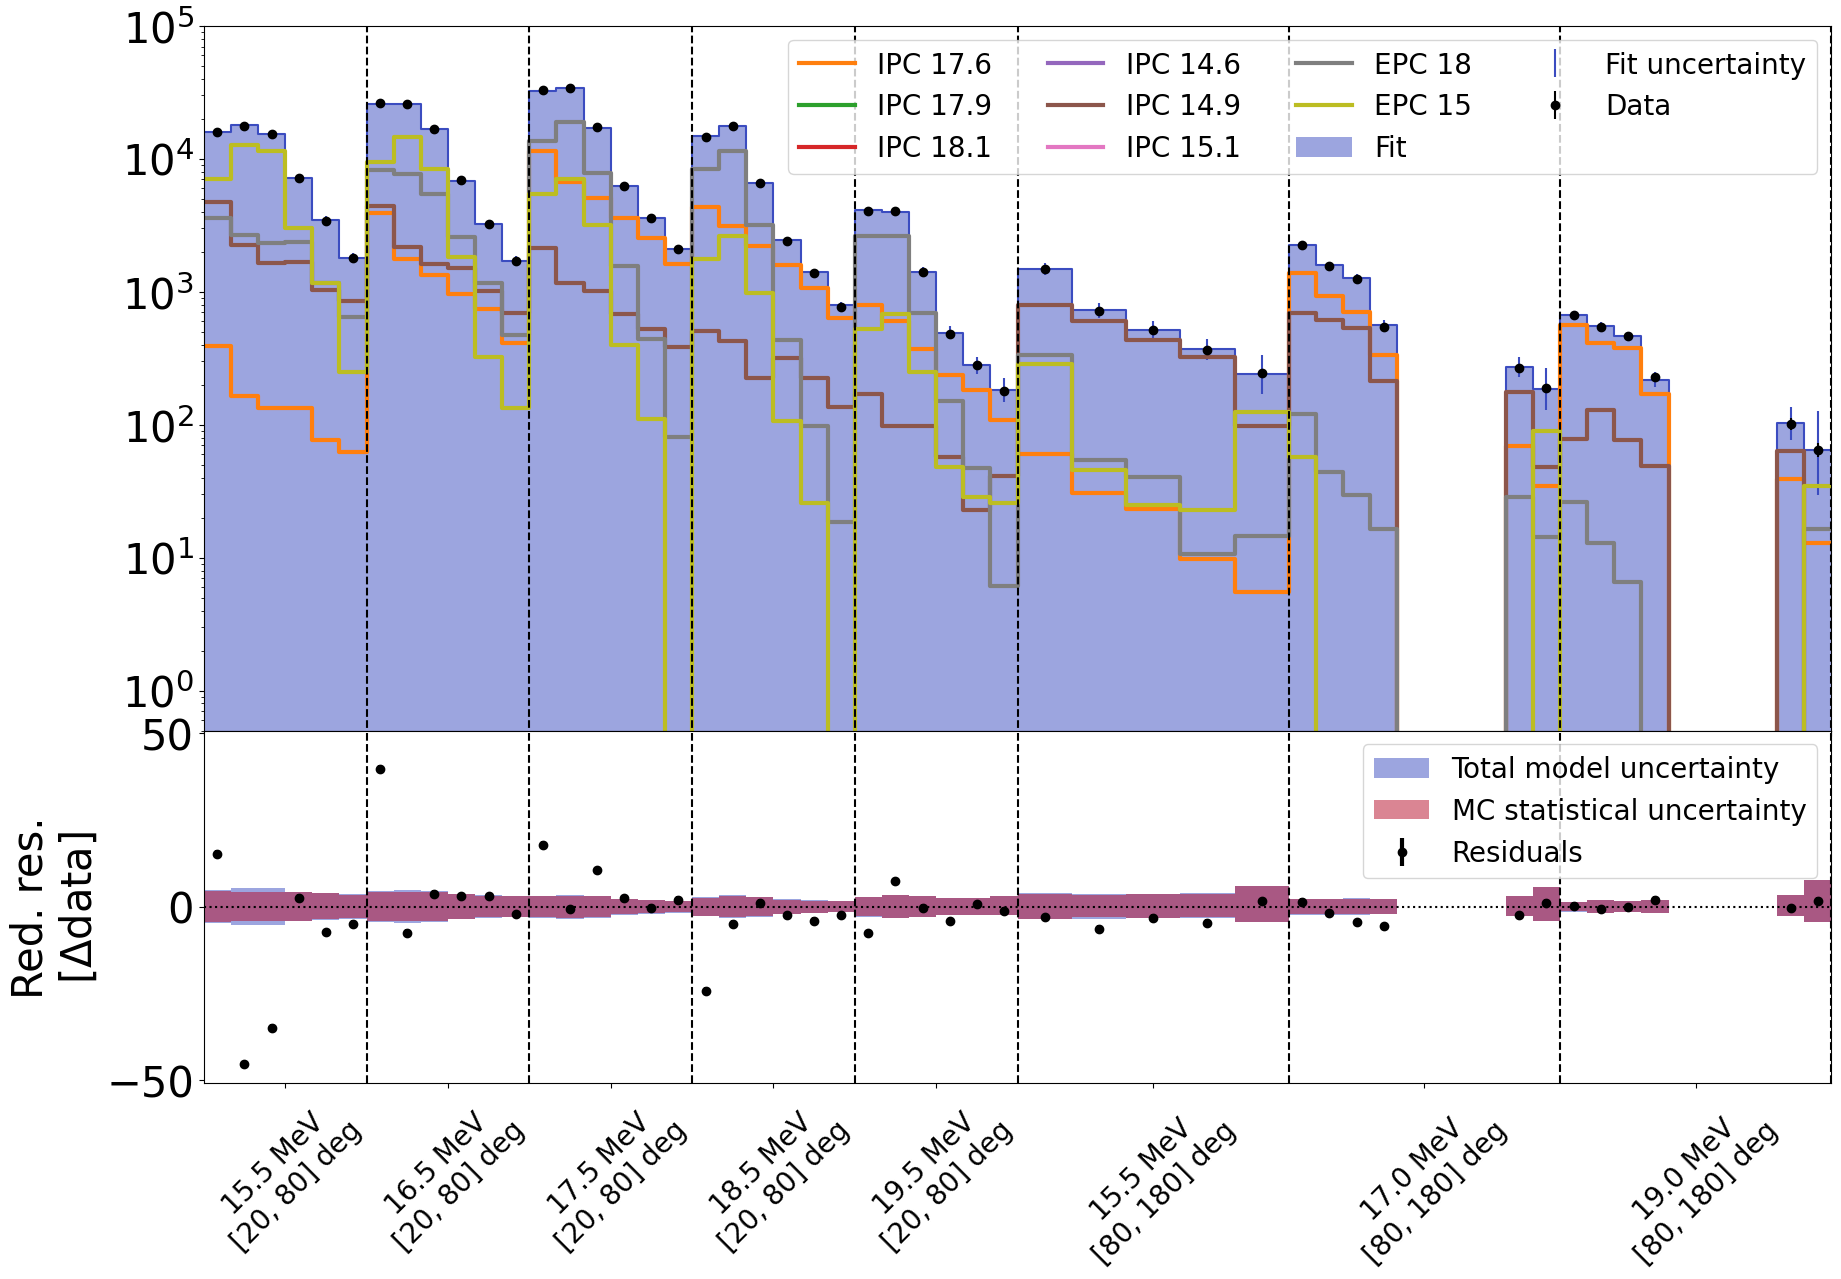

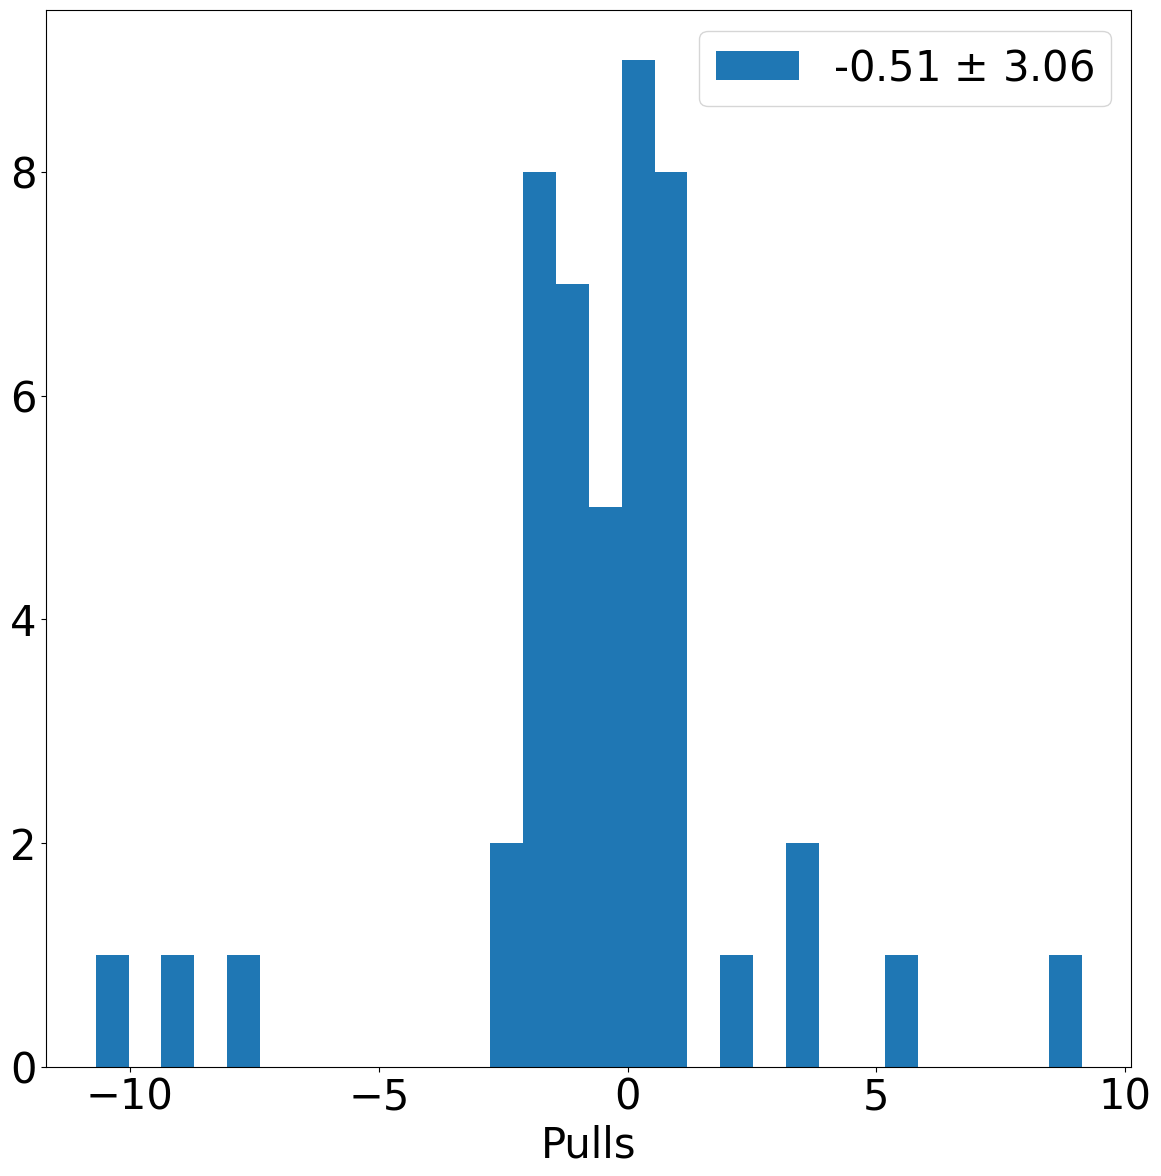

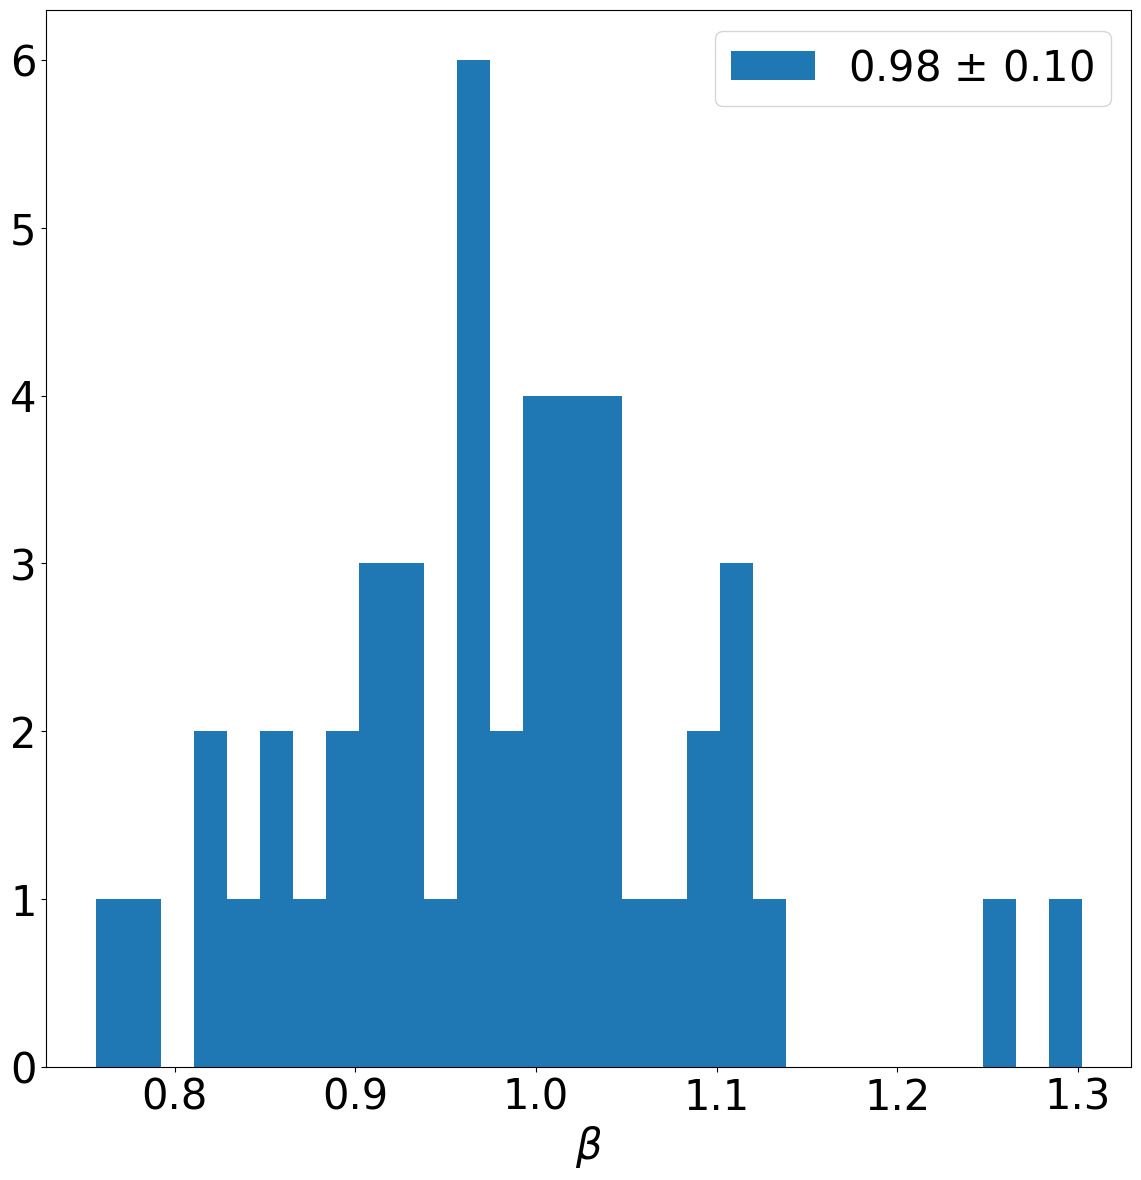

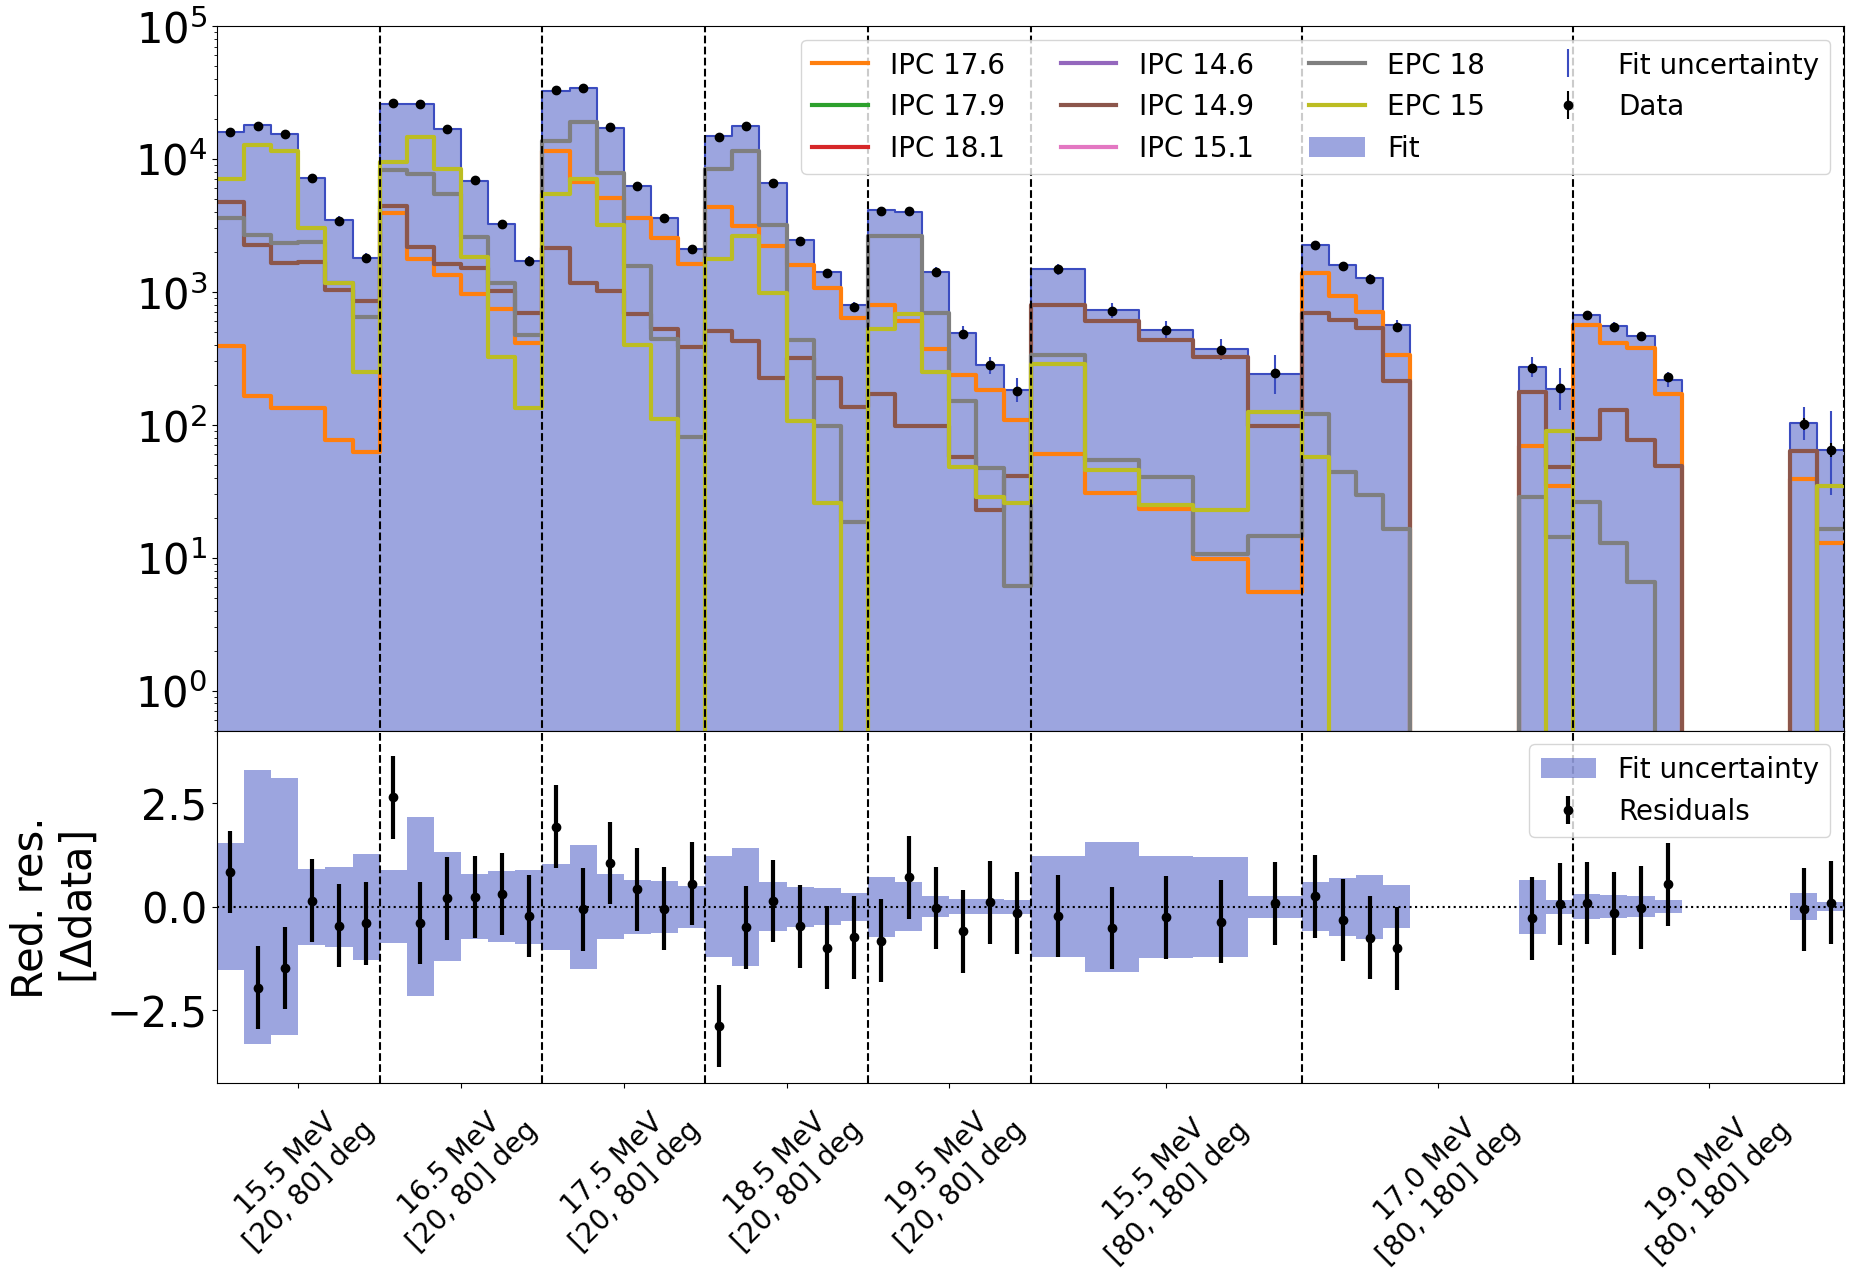

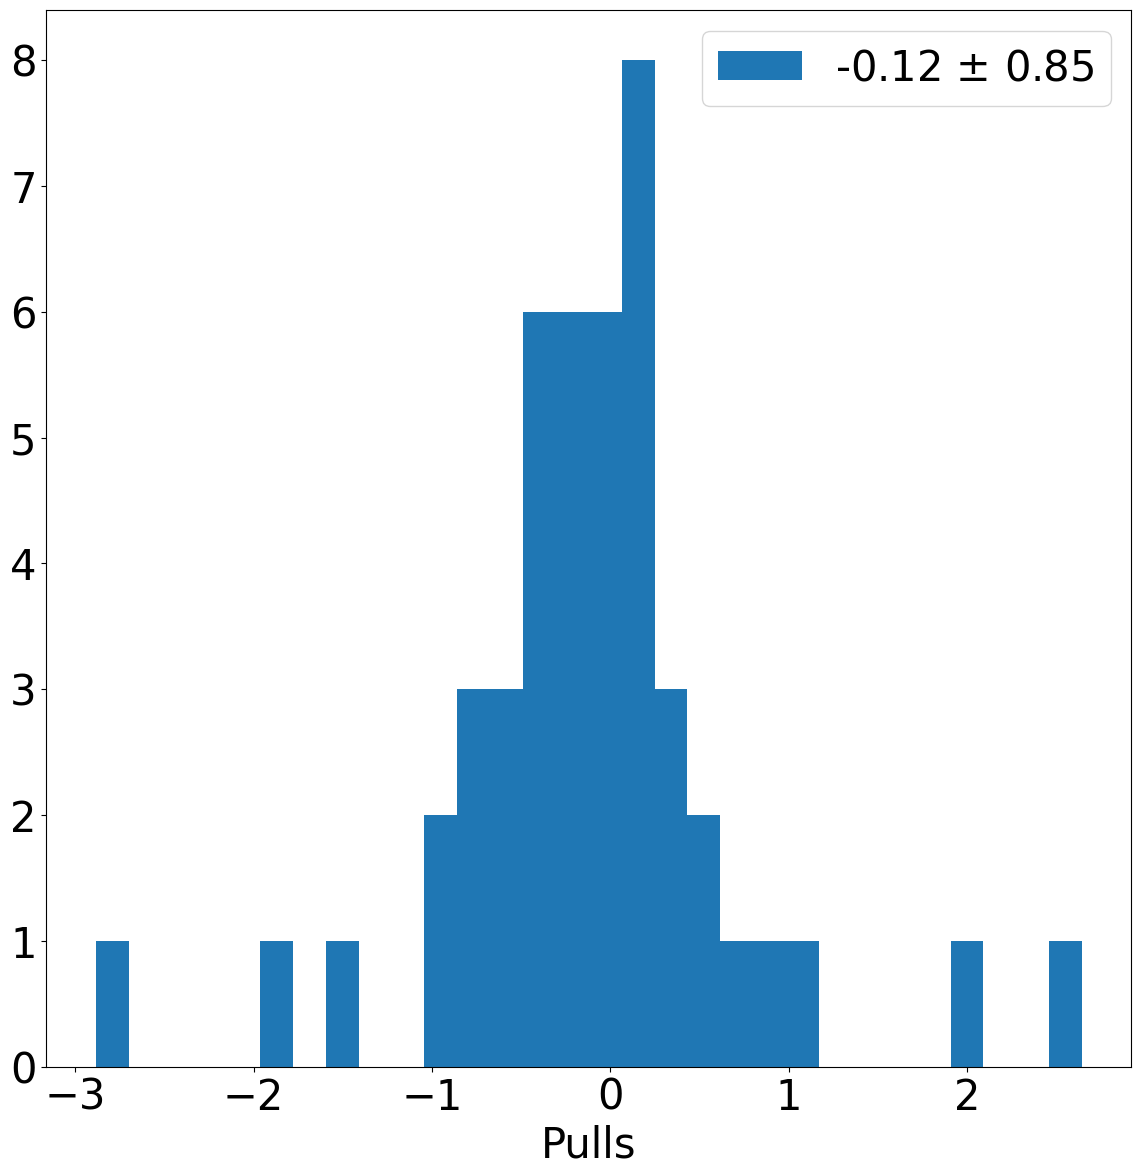

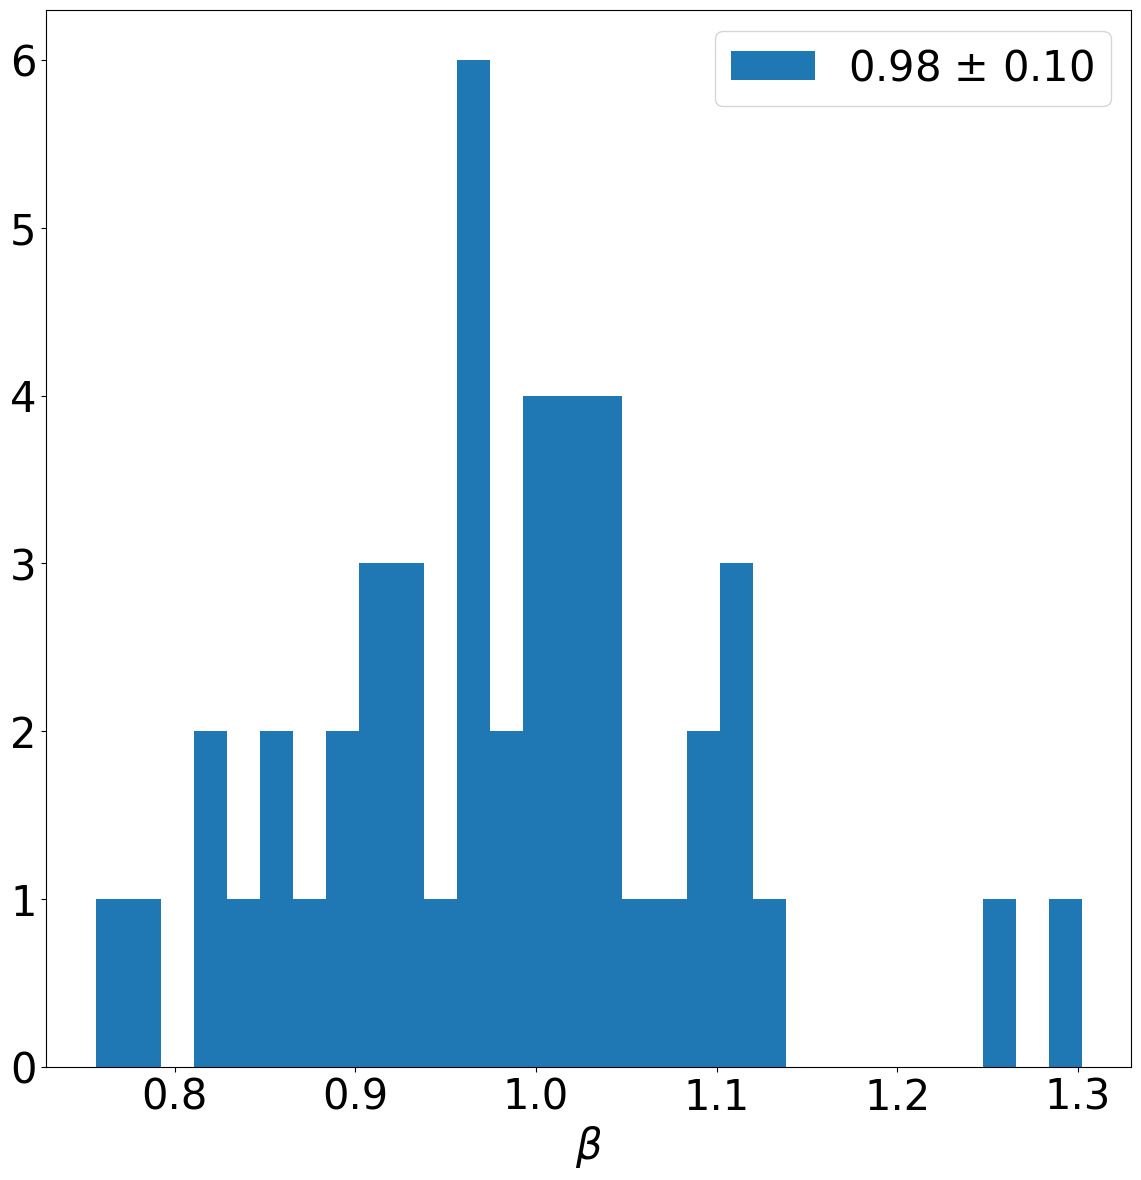

In [191]:
BETAS = betas

def plotComparison(Hists, pars, betas, compareWithBetas=True):
    matplotlib.rcParams.update({'font.size': 30})
    binWidths = np.array(combinedBins(Hists.channels))
    binCenters = [np.sum(binWidths[:i]) + binWidths[i]/2 for i in range(len(binWidths))]
    binSides = [np.sum(binWidths[:i]) for i in range(len(binWidths))]
    binSides.append(np.sum(binWidths))

    fig = plt.figure(figsize=(28*binWidths.sum()/800, 14), dpi=100)
    plt.subplots_adjust(hspace=0.0)
    plt.subplot(6, 1, (1, 4))

    # Bootstrap fit uncertainties
    tpars = np.random.multivariate_normal(logL.values, logL.covariance, size=10000)
    histEstimate = Hists.getEstimate(pars, betas)
    histEstimateError = Hists.getEstimateUncertainty(pars, betas)
    #tbetas = tpars[:, 8:]
    tpars = tpars[:, :8]
    histEstimate = Hists.getEstimate(pars, betas)
    histEstimateError = Hists.getEstimateUncertainty(pars, betas)
    histEstimate = []
    #for p, b in zip(tpars, tbetas):
    for p in tpars:
        tbetas = BBliteBeta(Hists.DataArray, Hists.getEstimate(p), Hists.getEstimateVariance(p))
        histEstimate.append(Hists.getEstimate(p, tbetas))
    histFitUncertainty = np.std(np.array(histEstimate), axis=0)


    histEstimate = Hists.getEstimate(pars, betas)
    histEstimateError = Hists.getEstimateUncertainty(pars, betas)
    #histEstimate, histEstimateError = cos.prediction(pars)
    effectiveHist = np.power(histEstimate/histEstimateError, 2)
    from scipy.stats import gamma
    def poissonErrors(h, cl = 0.68):
        # from: https://root-forum.cern.ch/t/poisson-errors-for-roohist/25688/7
        quantile = (1 - cl)/2
        lower = (h > 0)*gamma.ppf(quantile, h + (h == 0)) # if h == 0, lower = 0
        upper = gamma.isf(quantile, h + 1)*(h > 0) # if h == 0, upper = gamma.isf(quantile, 1
        return h - lower, upper - h

    histEstimateLower, histEstimateUpper = poissonErrors(effectiveHist)
    histEstimateLower = histEstimateLower*histEstimate/effectiveHist
    histEstimateUpper = histEstimateUpper*histEstimate/effectiveHist

    histEstimateUpperTot = np.sqrt(np.power(histEstimateUpper, 2) + np.power(histFitUncertainty, 2))
    histEstimateLowerTot = np.sqrt(np.power(histEstimateLower, 2) + np.power(histFitUncertainty, 2))

    # Plot data and fit
    plt.step(binSides, np.append(histEstimate, histEstimate[-1]), where='post',color = cm.coolwarm(0))
    plt.bar(binCenters, histEstimate, label='Fit', alpha=0.5, color = cm.coolwarm(0),  width=binWidths)
    plt.errorbar(binCenters, Hists.getEstimate(pars, betas), yerr=[histEstimateLowerTot, histEstimateUpperTot], fmt='none', label='Fit uncertainty', color = cm.coolwarm(0))
    plt.errorbar(binCenters, Hists.DataArray, yerr=np.sqrt(Hists.DataArray), label='Data', color = 'black', fmt='o')
    plt.yscale('log')
    plt.xlim(0, binSides[-1])
    plt.gca().axes.xaxis.set_ticklabels([])

    for i in range(len(pars)):
        parsEPC15 = np.zeros(len(pars))
        parsEPC15[i] = pars[i]
        histTempEstimate = Hists.getEstimate(parsEPC15, betas)
        print(BKGnames[i], startingPars[i], '->', np.sum(histTempEstimate), '+-', logL.errors[i]/pars[i]*np.sum(histTempEstimate))
        plt.step(binSides, np.append(histTempEstimate, histTempEstimate[-1]), where='post',color = f'C{i + 1}', linewidth=3, label = BKGnames[i])
    
    # Plot a vertical line to separate the Esum bins
    index = 0
    xticks = []
    xtickslabels = []
    for channel in Hists.channels.keys():
        esumBins = np.linspace(Hists.channels[channel]['Esum'][0], Hists.channels[channel]['Esum'][1], Hists.channels[channel]['Esum'][2]+1)
        esumBins = (esumBins[1:] + esumBins[:-1])/2
        minAngle = Hists.channels[channel]['Angle'][0]
        maxAngle = Hists.channels[channel]['Angle'][1]
        for esum in esumBins:
            index = index + Hists.channels[channel]['Angle'][2]
            plt.vlines(binSides[index], 0, 1e5, colors='k', linestyles='dashed')
            # Text inside the box
            xticks.append(0.5*(binSides[index] + binSides[index-Hists.channels[channel]['Angle'][2]]))
            xtickslabels.append(f'{esum:.1f} MeV\n[{minAngle}, {maxAngle}] deg')
    
    plt.legend(loc='upper right', ncol=int(len(BKGnames)*0.5), fontsize=20)
    
    plt.ylim(0.5, 1e5)
    
    plt.subplot(6, 1, (5,6))
    if compareWithBetas:
        histEstimate = Hists.getEstimate(pars, 1)
    
    dDataHist = np.sqrt(Hists.DataArray)
    reddData = dDataHist/(histEstimate + (histEstimate == 0))
    redExpectedFit = histFitUncertainty/(histEstimate + (histEstimate == 0))
    redExpectedHistLower = histEstimateLower/(histEstimate + (histEstimate == 0))
    redExpectedHistUpper = histEstimateUpper/(histEstimate + (histEstimate == 0))
    redExpectedHistLowerTot = histEstimateLowerTot/(histEstimate + (histEstimate == 0))
    redExpectedHistUpperTot = histEstimateUpperTot/(histEstimate + (histEstimate == 0))
    redResiduals = (Hists.DataArray - histEstimate)/(histEstimate + (histEstimate == 0))
    
    redExpectedFit = redExpectedFit/reddData
    redExpectedHistLower = redExpectedHistLower/reddData
    redExpectedHistUpper = redExpectedHistUpper/reddData
    redExpectedHistLowerTot = redExpectedHistLowerTot/reddData
    redExpectedHistUpperTot = redExpectedHistUpperTot/reddData
    redResiduals = redResiduals/reddData
    reddData = reddData/reddData
    
    if compareWithBetas:
        plt.bar(binCenters, redExpectedHistLowerTot + redExpectedHistUpperTot, bottom = -redExpectedHistLowerTot, color = cm.coolwarm(0), alpha=0.5, label='Total model uncertainty', width=binWidths)
        plt.bar(binCenters, redExpectedHistLower + redExpectedHistUpper, bottom = -redExpectedHistLower, color = cm.coolwarm(0.99), alpha=0.5, label='MC statistical uncertainty', width=binWidths)
    else:
        plt.bar(binCenters, 2*redExpectedFit, bottom = -redExpectedFit, color = cm.coolwarm(0), alpha=0.5, label='Fit uncertainty', width=binWidths)
    
    plt.errorbar(binCenters, redResiduals, yerr=reddData, fmt='o', color = 'k', label='Residuals', linewidth=3)
    plt.xlim(0, binSides[-1])
    plt.legend(loc='upper right', fontsize=20)
    plt.ylabel('Red. res.\n' + r'[$\Delta$data]')
    miny = plt.ylim()[0]
    maxy = plt.ylim()[1]
    maxy = np.max([np.abs(miny), np.abs(maxy)])
    miny = -maxy
    index = 0
    for channel in channels.keys():
        esumBins = np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1)
        esumBins = (esumBins[1:] + esumBins[:-1])/2
        minAngle = channels[channel]['Angle'][0]
        maxAngle = channels[channel]['Angle'][1]
        for esum in esumBins:
            index = index + channels[channel]['Angle'][2]
            plt.vlines(binSides[index], miny, maxy, colors='k', linestyles='dashed')
    plt.hlines(0, 0, binSides[-1], colors='k', linestyles='dotted')

    plt.ylim(miny, maxy)

    plt.gca().set_xticks(xticks)
    plt.gca().set_xticklabels(xtickslabels, fontsize=20)
    plt.xticks(rotation=45)
    
    fig = plt.figure(figsize=(14, 14), dpi=100)
    if compareWithBetas:
        pulls = (Hists.DataArray - histEstimate)/np.sqrt(dDataHist**2 +  + histEstimateError**2  + (dDataHist == 0)) * (dDataHist > 0)
    else:
        pulls = (Hists.DataArray - histEstimate)/np.sqrt(dDataHist**2 + (dDataHist == 0)) * (dDataHist > 0)# + histEstimateError**2  + (histEstimate == 0))
    pulls = pulls[Hists.DataArray != 0]
    plt.hist(pulls, label= f'{pulls.mean():.2f} $\pm$ {pulls.std():.2f}', bins=30)
    plt.legend()
    plt.xlabel('Pulls')
    print('chi2:', np.sum(pulls**2))
    print('dof:', len(pulls) - len(pars))
    pvalue = chi2.sf(np.sum(pulls**2), len(pulls) - len(pars))
    print('p-value:', pvalue)
    zscore = norm.isf(pvalue/2)
    print('Z-score:', zscore)
    
    fig = plt.figure(figsize=(14, 14), dpi=100)
    plt.hist(betas[Hists.DataArray != 0], bins=30, label=f'{betas.mean():.2f} $\pm$ {betas.std():.2f}')
    plt.legend()
    plt.xlabel(r'$\beta$')
    
    
        
plotComparison(Hists, pars, betas, compareWithBetas=True)
plotComparison(Hists, pars, betas, compareWithBetas=False)

Do Minos plot

In [192]:
#for name in logL.parameters:
#    matplotlib.rcParams.update({'font.size': 30})
#    fig = plt.figure(figsize=(21, 14), dpi=100)
#    logL.draw_profile(name)
#    plt.ylim(0, plt.gca().get_ylim()[1])
#plt.plot(logL.values['nEPC15'], logL.values['nEPC18'], 'o', label='Best fit')


In [193]:
#%%capture --no-display
## Draw contours
#matplotlib.rcParams.update({'font.size': 25})
#fig = plt.figure(figsize=(50, 50), dpi=100)
#plt.set_cmap('Set1')
#plt.subplot(8, 8, 1)
#
#maxX = np.zeros(8)
#minX = np.zeros(8) + 1e9
#maxY = np.zeros(8)
#minY = np.zeros(8) + 1e9
#
#for i in range(8):
#    for j in range(8):
#        if i > j:
#            try:
#                plt.subplot(8, 8, 8*i + j + 1)
#                logL.draw_mncontour(logL.parameters[j], logL.parameters[i], cl=[1,2,3])
#                #logL.draw_contour(logL.parameters[j], logL.parameters[i], cl=[1,2,3])
#                plt.xlabel(logL.parameters[j])
#                plt.ylabel(logL.parameters[i])
#                plt.plot(logL.values[logL.parameters[j]], logL.values[logL.parameters[i]], '+', label='Best fit', markersize = 25)
#            except:
#                plt.plot(logL.values[logL.parameters[j]], logL.values[logL.parameters[i]], '+', label='Best fit', markersize = 25)
#            if minX[j] > plt.gca().get_xlim()[0]:
#                minX[j] = plt.gca().get_xlim()[0]
#            if maxX[j] < plt.gca().get_xlim()[1]:
#                maxX[j] = plt.gca().get_xlim()[1]
#            if minY[i] > plt.gca().get_ylim()[0]:
#                minY[i] = plt.gca().get_ylim()[0]
#            if maxY[i] < plt.gca().get_ylim()[1]:
#                maxY[i] = plt.gca().get_ylim()[1]
#            if j != 0:
#                plt.gca().axes.yaxis.set_ticklabels([])
#                plt.gca().axes.yaxis.set_ticks([])
#            if i != 7:
#                plt.gca().axes.xaxis.set_ticklabels([])
#                plt.gca().axes.xaxis.set_ticks([])
#        elif i == j:
#            plt.subplot(8, 8, 8*i + j + 1)
#            logL.draw_mnprofile(logL.parameters[j])
#            plt.vlines(logL.values[logL.parameters[j]], 0, plt.gca().get_ylim()[1], label='Best fit')
#            plt.legend()
#            plt.xlabel(logL.parameters[j])
#            plt.gca().set_title(logL.parameters[j] + ' = ' + f'{logL.values[logL.parameters[j]]:.2e}')
#            if minX[j] > plt.gca().get_xlim()[0]:
#                minX[j] = plt.gca().get_xlim()[0]
#            if maxX[j] < plt.gca().get_xlim()[1]:
#                maxX[j] = plt.gca().get_xlim()[1]
#for i in range(8):
#    for j in range(8):
#        if i >= j:
#            plt.subplot(8, 8, 8*i + j + 1)
#            if i != j:
#                plt.ylim(0.9*minY[i], maxY[i]*1.1)
#                plt.xlim(0.9*minX[j], maxX[j]*1.1)
#            else:
#                plt.ylim(0, plt.gca().get_ylim()[1])
#            
#
#plt.text(0.65, 0.65, 'Profile\nlikelihoods', fontsize=100, ha='center', va='center', transform=plt.gcf().transFigure)
#print(minX, maxX, minY, maxY)


## Toy MCs

99
[[9.23805477e-11 1.14229479e+04 1.67223568e-10 9.70334924e-14
  3.07525024e+05 1.24527055e-11 2.06213624e-09 1.87072580e-12]]


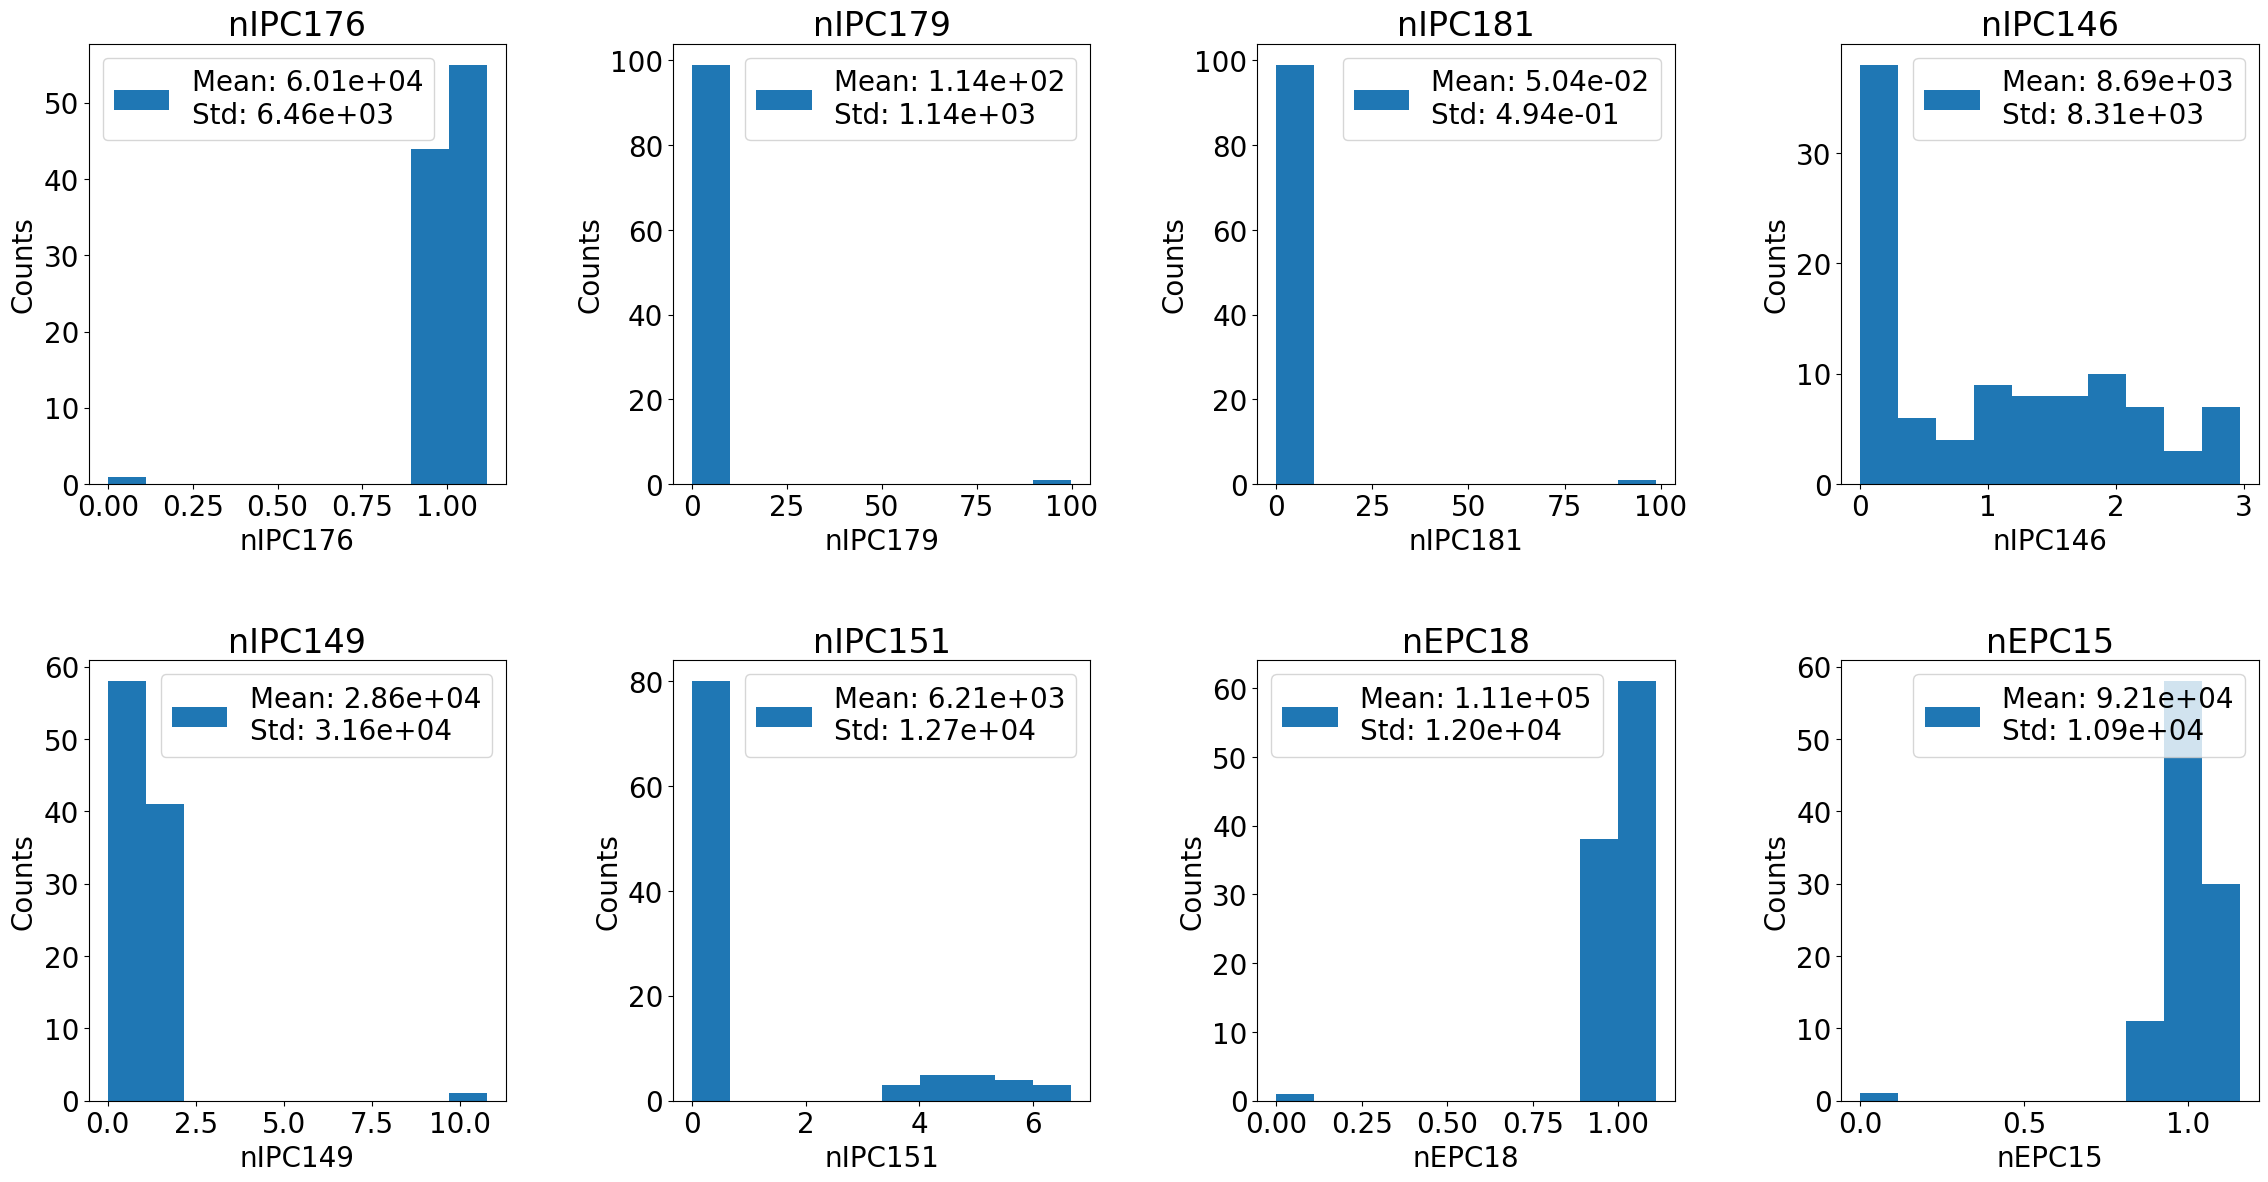

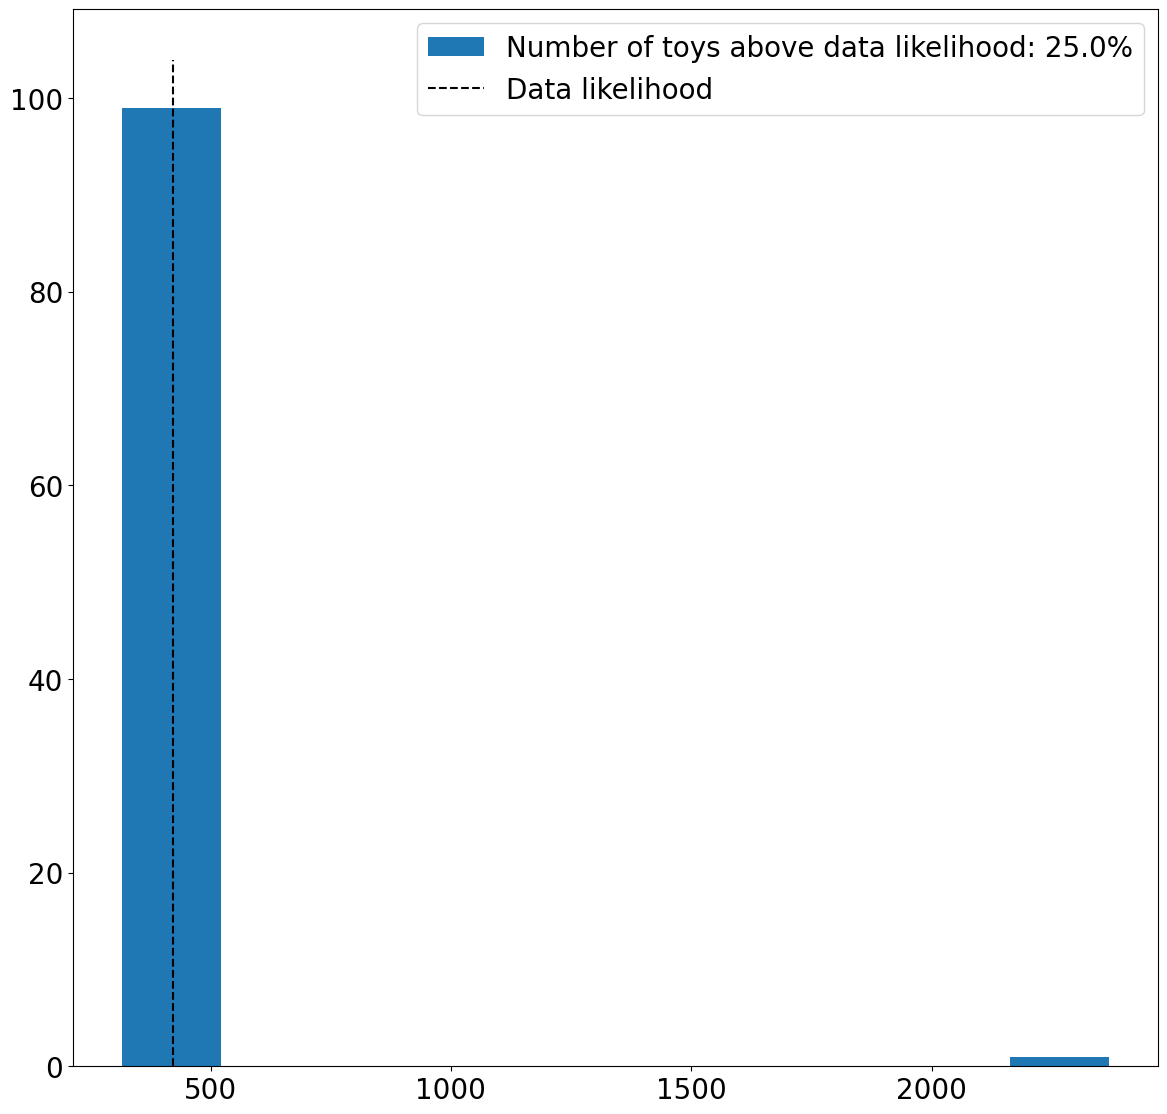

In [198]:
matplotlib.rcParams.update({'font.size': 20})

def generateToy(Hists, betas, pars):
    dataToy = np.random.poisson(Hists.getEstimate(pars, betas))
    return dataToy

def llBKGToy(pars):
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15 = pars
    yields = np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = Hists.getEstimateToy(yields)
    Vmu0 = Hists.getEstimateVarianceToy(yields)
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(Hists.DataArrayToy, mu0, mueff)
    
    mu = Hists.getEstimateToy(yields, betas)
    
    return likelihood(Hists.DataArrayToy, 0, mu, mueff, betas, 0)

PARS = []
Likelihood = []
for i in range(100):
    np.random.seed(i)
    # Create copy of the Hists object
    tpars = np.random.multivariate_normal(pars, covariance)
    Hists.generateToy(tpars, betas = betas, fluctuateTemplates = True)
    logL = Minuit(llBKGToy, tpars, name=['nIPC176', 'nIPC179', 'nIPC181', 'nIPC146', 'nIPC149', 'nIPC151', 'nEPC18', 'nEPC15'])
    for j in range(len(pars)):
        logL.limits[j] = (0, None)
    logL.simplex(ncall=100000)
    logL.strategy = 2
    logL.tol = 1e-10
    logL.migrad(ncall=100000, iterate=5)
    for j in range(5):
        logL.scan(ncall=1e4)
    logL.migrad(ncall=100000, iterate=5)
    logL.hesse()
    PARS.append(np.array(logL.values))
    Likelihood.append(logL.fval)

PARS = np.array(PARS)
Likelihood = np.array(Likelihood)

fig = plt.figure(figsize=(28, 14), dpi=100)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(logL.parameters)):
    plt.subplot(2, 4, i+1)
    tpars = np.array([p[i] for p in PARS[Likelihood < 10000]])
    plt.hist(tpars/tpars.mean(), label= f'Mean: {tpars.mean():.2e}\nStd: {tpars.std():.2e}')
    plt.xlabel(logL.parameters[i])
    plt.ylabel('Counts')
    plt.legend()
    plt.title(logL.parameters[i])

fig = plt.figure(figsize=(14, 14), dpi=100)
plt.hist(Likelihood[Likelihood < 10000], label= 'Number of toys above data likelihood: ' + f'{np.sum(np.array(Likelihood) > MAXLikelihood)/len(Likelihood)*100:.1f}%')
plt.vlines(MAXLikelihood, 0, plt.gca().get_ylim()[1], label='Data likelihood', color='k', linestyles='dashed')
plt.legend()

print(len(Likelihood[Likelihood < 1000]))
print(PARS[Likelihood > 1000])
# Save parameters and likelihood with numpy seed to reproduce
np.save('toyParameters.npy', zip(np.linspace(0, len(PARS), len(PARS)), PARS, Likelihood))

# Template morphing

Systematic effects affecting the shape of the templates are included through morphing. For some reference values of the systematic uncertainty in exam,  the templates are comoputed and then interpolated. Usually this is done for the nominal value and the +-1 sigma variations on that systematic. There are different approaches to perform the interpolation:
* Vertical morphing: the templates are interpolated on a binwise basis, so that bin $i$ of the morphed template is the weighted sum only of bin $i$ in the reference templates. This is the most straightforward approach but has a fallback: if the reference templates are far apart in the evalutaion points, the interpolation in between ranges can result in multi-modal distributions.
* Horizontal morphing: the interpolation is done on the cumulative distributions. This allows to shift the mean and the variance of the distributions and correctly interpolate between them. In the literature this is referred to as "expensive" computationally. In numpy the operation of creating a distribution from a cumulative distribution is rather quick, so we could try it. It does not have a natural extensio to higher dimensional histograms, but one can still try building a monodimensional cumulative out of our 2D distributions. This introduces correlations between the bins, so the complete BB likelihood cannot be simplified to a set of independent equations anymore.
* Moment morphing: the interpolation is still vertical, but before summing the weighted bins they are shifted and scaled so that the mean and variance of the distributions are the same and correspond to their weighted average. This naturally allows an extension to higher dimension histograms. The way to combine and scale neighboring bins is not unique, so one needs to make a choice.

The interpolation in all cases is done as in [HistFactory](https://cds.cern.ch/record/1456844/files/CERN-OPEN-2012-016.pdf) interpCode = 4. The interpolation is done with a 6D polynomial and the extrapolation is done with an exponential.

In [195]:
class interpolator():
    # histogramsets[:, :, ]
    def __init__(self, histogramssets, alpha0=1):
            assert alpha0 > 0
            self.__alpha0 = alpha0
            
            self._histogramssets = np.array(histogramssets)
            self.alphasets_shape = (self._histogramssets.shape[0], 1)
            
            # precompute terms that only depend on the histogramssets
            self._deltas_up = np.divide(
                self._histogramssets[:, :, 2], self._histogramssets[:, :, 1]
            )
            self._deltas_dn = np.divide(
                self._histogramssets[:, :, 0], self._histogramssets[:, :, 1]
            )
            self._broadcast_helper = np.ones(
                np.shape(self._deltas_up)
            )
            self._alpha0 = self._broadcast_helper * self.__alpha0
            
            deltas_up_alpha0 = np.power(self._deltas_up, self._alpha0)
            deltas_dn_alpha0 = np.power(self._deltas_dn, self._alpha0)

            A_inverse = np.array(
            [
                [
                    15.0 / (16 * alpha0),
                    -15.0 / (16 * alpha0),
                    -7.0 / 16.0,
                    -7.0 / 16.0,
                    1.0 / 16 * alpha0,
                    -1.0 / 16.0 * alpha0,
                ],
                [
                    3.0 / (2 * np.power(alpha0, 2)),
                    3.0 / (2 * np.power(alpha0, 2)),
                    -9.0 / (16 * alpha0),
                    9.0 / (16 * alpha0),
                    1.0 / 16,
                    1.0 / 16,
                ],
                [
                    -5.0 / (8 * np.power(alpha0, 3)),
                    5.0 / (8 * np.power(alpha0, 3)),
                    5.0 / (8 * np.power(alpha0, 2)),
                    5.0 / (8 * np.power(alpha0, 2)),
                    -1.0 / (8 * alpha0),
                    1.0 / (8 * alpha0),
                ],
                [
                    3.0 / (-2 * np.power(alpha0, 4)),
                    3.0 / (-2 * np.power(alpha0, 4)),
                    -7.0 / (-8 * np.power(alpha0, 3)),
                    7.0 / (-8 * np.power(alpha0, 3)),
                    -1.0 / (8 * np.power(alpha0, 2)),
                    -1.0 / (8 * np.power(alpha0, 2)),
                ],
                [
                    3.0 / (16 * np.power(alpha0, 5)),
                    -3.0 / (16 * np.power(alpha0, 5)),
                    -3.0 / (16 * np.power(alpha0, 4)),
                    -3.0 / (16 * np.power(alpha0, 4)),
                    1.0 / (16 * np.power(alpha0, 3)),
                    -1.0 / (16 * np.power(alpha0, 3)),
                ],
                [
                    1.0 / (2 * np.power(alpha0, 6)),
                    1.0 / (2 * np.power(alpha0, 6)),
                    -5.0 / (16 * np.power(alpha0, 5)),
                    5.0 / (16 * np.power(alpha0, 5)),
                    1.0 / (16 * np.power(alpha0, 4)),
                    1.0 / (16 * np.power(alpha0, 4)),
                ],
            ]
            )
            b = np.stack(
                [
                    deltas_up_alpha0 - self._broadcast_helper,
                    deltas_dn_alpha0 - self._broadcast_helper,
                    np.log(self._deltas_up) * deltas_up_alpha0,
                    -np.log(self._deltas_dn) * deltas_dn_alpha0,
                    np.power(np.log(self._deltas_up), 2)
                    * deltas_up_alpha0,
                    np.power(np.log(self._deltas_dn), 2)
                    * deltas_dn_alpha0,
                ]
            )
            self._coefficients = np.einsum(
                'rc,shb,cshb->rshb', A_inverse, self._broadcast_helper, b
            )

            self._precompute()
    
    def _precompute(self):
        self.deltas_up = np.array(self._deltas_up)
        self.deltas_dn = np.array(self._deltas_dn)
        self.broadcast_helper = np.array(self._broadcast_helper)
        self.alpha0 = np.array(self._alpha0)
        self.coefficients = np.array(self._coefficients)
        self.bases_up = np.einsum(
            'sa,shb->shab', np.ones(self.alphasets_shape), self.deltas_up
        )
        self.bases_dn = np.einsum(
            'sa,shb->shab', np.ones(self.alphasets_shape), self.deltas_dn
        )
        self.mask_on = np.ones(self.alphasets_shape)
        self.mask_off = np.zeros(self.alphasets_shape)
        self.ones = np.einsum(
            'sa,shb->shab', self.mask_on, self.broadcast_helper
        )

    def _precompute_alphasets(self, alphasets_shape):
        if alphasets_shape == self.alphasets_shape:
            return
        self.alphasets_shape = alphasets_shape
        self.bases_up = np.einsum(
            'sa,shb->shab', np.ones(self.alphasets_shape), self.deltas_up
        )
        self.bases_dn = np.einsum(
            'sa,shb->shab', np.ones(self.alphasets_shape), self.deltas_dn
        )
        self.mask_on = np.ones(self.alphasets_shape)
        self.mask_off = np.zeros(self.alphasets_shape)
        self.ones = np.einsum(
            'sa,shb->shab', self.mask_on, self.broadcast_helper
        )
        return

    def __call__(self, alphasets):
        """Compute Interpolated Values."""
        self._precompute_alphasets(np.shape(alphasets))

        # select where alpha >= alpha0 and produce the mask
        where_alphasets_gtalpha0 = np.where(
            alphasets >= self.__alpha0, self.mask_on, self.mask_off
        )
        masks_gtalpha0 = np.array(
            np.einsum(
                'sa,shb->shab', where_alphasets_gtalpha0, self.broadcast_helper
            ),
            dtype="bool",
        )

        # select where alpha > -alpha0 ["not(alpha <= -alpha0)"] and produce the mask
        where_alphasets_not_ltalpha0 = np.where(
            alphasets > -self.__alpha0, self.mask_on, self.mask_off
        )
        masks_not_ltalpha0 = np.array(
            np.einsum(
                'sa,shb->shab', where_alphasets_not_ltalpha0, self.broadcast_helper
            ),
            dtype="bool",
        )

        # s: set under consideration (i.e. the modifier)
        # a: alpha variation
        # h: histogram affected by modifier
        # b: bin of histogram
        exponents = np.einsum(
            'sa,shb->shab', np.abs(alphasets), self.broadcast_helper
        )
        # for |alpha| >= alpha0, we want to raise the bases to the exponent=alpha
        # and for |alpha| < alpha0, we want to raise the bases to the exponent=1
        masked_exponents = np.where(
            exponents >= self.__alpha0, exponents, self.ones
        )
        # we need to produce the terms of alpha^i for summing up
        alphasets_powers = np.stack(
            [
                alphasets,
                np.power(alphasets, 2),
                np.power(alphasets, 3),
                np.power(alphasets, 4),
                np.power(alphasets, 5),
                np.power(alphasets, 6),
            ]
        )
        # this is the 1 + sum_i a_i alpha^i
        value_btwn = np.ones(exponents.shape) + np.einsum(
            'rshb,rsa->shab', self.coefficients, alphasets_powers
        )

        # first, build a result where:
        #       alpha > alpha0   : fill with bases_up
        #   not(alpha > alpha0)  : fill with 1 + sum(a_i alpha^i)
        results_gtalpha0_btwn = np.where(
            masks_gtalpha0, self.bases_up, value_btwn
        )
        # then, build a result where:
        #      alpha >= -alpha0  : do nothing (fill with previous result)
        #   not(alpha >= -alpha0): fill with bases_dn
        bases = np.where(
            masks_not_ltalpha0, results_gtalpha0_btwn, self.bases_dn
        )
        return np.power(bases, masked_exponents)
